In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:

# Load preprocessed data
df = pd.read_csv("processed_data.csv")

In [6]:
# Define input features (including past NISLL)
features = df.columns.difference(["Patient", "Visite_date", "NISLL"]).tolist()
target = "NISLL"

In [9]:
# Normalize input features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [10]:
df[features]

,ExternalPoplitealSciaticMotorLeft_Foot_DorsalisPedis,ExternalPoplitealSciaticMotorRight_Foot_DorsalisPedis,Inotersen,InternalPoplitealSciaticMotorLeft_Ankle_CFPI,InternalPoplitealSciaticMotorRight_Ankle_CFPI,MedianDistalLatencyLeft,MedianDistalLatencyRight,MedianMotorLeft_Wrist_ThumbAbduction,MedianMotorRight_Wrist_ThumbAbduction,MedianSensoryLeft,...,RadialSensoryLeft,RadialSensoryRight,SuralSensitifD,SuralSensoryLeft,Tafamidis,UlnarMotorLeft_Wrist_FingerAdduction,UlnarMotorRight_Wrist_FingerAdduction,UlnarSensoryLeft,UlnarSensoryRight,Vutrisiran
0,0.211538,0.083695,0.0,0.139466,0.442211,0.426126,0.389431,0.535211,0.273917,0.061584,...,0.242609,0.221846,0.131757,0.166917,1.0,0.471506,0.522054,0.083558,0.084875,0.0
1,0.403846,0.071930,0.0,0.101695,0.427136,0.385818,0.326346,0.545689,0.503317,0.123167,...,0.312047,0.236646,0.236486,0.255639,1.0,0.559885,0.473956,0.196051,0.119718,0.0
2,0.126923,0.028947,0.0,0.110169,0.386935,0.458767,0.378882,0.419877,0.434815,0.080645,...,0.262273,0.176859,0.131757,0.131579,1.0,0.481333,0.411898,0.236953,0.174296,0.0
3,0.307692,0.024561,0.0,0.169492,0.452261,0.375686,0.323336,0.379780,0.358511,0.060117,...,0.217563,0.179883,0.202703,0.308271,1.0,0.505847,0.489031,0.112835,0.142606,0.0
4,0.211538,0.041228,0.0,0.149718,0.457286,0.457658,0.343089,0.500000,0.237875,0.080645,...,0.232938,0.215872,0.172297,0.161654,1.0,0.568966,0.664062,0.159379,0.128521,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.211538,0.192982,0.0,0.066384,0.125628,0.619820,0.437398,0.295775,0.281125,0.026686,...,0.111631,0.088067,0.000000,0.154135,1.0,0.413793,0.367188,0.062059,0.065141,0.0
438,0.201923,0.192982,0.0,0.059322,0.125628,0.574775,0.392683,0.176056,0.302750,0.020674,...,0.086011,0.118435,0.185811,0.086466,1.0,0.387931,0.343750,0.038082,0.040493,0.0
439,0.031731,0.166667,0.0,0.066384,0.042714,0.407979,0.398234,0.197156,0.161903,0.046921,...,0.082351,0.130930,0.000000,0.000000,0.0,0.326276,0.306497,0.010833,0.037235,0.0
440,0.122115,0.080702,0.0,0.059322,0.150754,0.252252,0.243089,0.352113,0.396458,0.074780,...,0.100651,0.081993,0.000000,0.090226,1.0,0.560345,0.437500,0.060649,0.000000,0.0


In [11]:
# Function to create sequences predicting the next available visit

def create_sequences(data, feature_cols, target_col):
    sequences,targets = [], []
    patients = data["Patient"].unique()

    for patient in patients:
        patient_data = data[data["Patient"] == patient].sort_values("Visite_date")
        num_visits = len(patient_data)

        for i in range(num_visits -1): # Stop at the second to last visit
            past_data = patient_data.iloc[:i+1][feature_cols].values      # All history up to visit i
            target_val = patient_data.iloc[i+1][target_col]               # Predict next visit's NISLL

            sequences.append(past_data)     
            targets.append(target_val)
    return sequences, np.array(targets)

In [118]:
# Create dataset (predicting NISLL at next visit)
X_list, y = create_sequences(df, features + ["NISLL"] , target)

In [119]:
# Pad sequences to max length
X = pad_sequences(X_list, padding='pre', dtype='float32') # Pre-padding for LSTM

In [120]:
# SPlit train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
# Define LSTM model with masking (to handle variable length sequences)

model = Sequential([
    Masking(mask_value=0., input_shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=True, activation="relu"),
    Dropout(0.2),
    LSTM(32, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1)  # Predicting NISLL at the next visit
])

In [122]:
# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])    

In [123]:
# Train model
model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/200
18/18 [==============================] - 3s 41ms/step - loss: 567.8263 - mae: 17.5273 - val_loss: 491.1659 - val_mae: 14.5188
Epoch 2/200
18/18 [==============================] - 0s 12ms/step - loss: 395.0006 - mae: 13.9868 - val_loss: 427.8127 - val_mae: 13.2087
Epoch 3/200
18/18 [==============================] - 0s 12ms/step - loss: 292.5797 - mae: 11.8527 - val_loss: 315.0626 - val_mae: 10.4373
Epoch 4/200
18/18 [==============================] - 0s 12ms/step - loss: 228.3018 - mae: 10.0800 - val_loss: 289.5054 - val_mae: 10.5127
Epoch 5/200
18/18 [==============================] - 0s 11ms/step - loss: 168.8353 - mae: 8.5770 - val_loss: 225.4422 - val_mae: 9.0036
Epoch 6/200
18/18 [==============================] - 0s 11ms/step - loss: 165.5030 - mae: 8.6293 - val_loss: 218.0591 - val_mae: 8.3735
Epoch 7/200
18/18 [==============================] - 0s 11ms/step - loss: 128.2082 - mae: 7.7071 - val_loss: 155.8950 - val_mae: 6.6773
Epoch 8/200
18/18 [=====================

In [124]:
# Predict NISLL at next visits
predictions = model.predict(X_test)

3/3 [==============================] - 0s 5ms/step


In [125]:
# Print sample predictions
print("Sample Predictions:", predictions[:5])

Sample Predictions: [[ 3.1018972]
 [ 9.100355 ]
 [38.792664 ]
 [24.968176 ]
 [63.484802 ]]


In [126]:
# Add predicted NISLL scores back to the test set
predicted_nisll = predictions.flatten()  # Flatten the predictions array to match the number of test samples


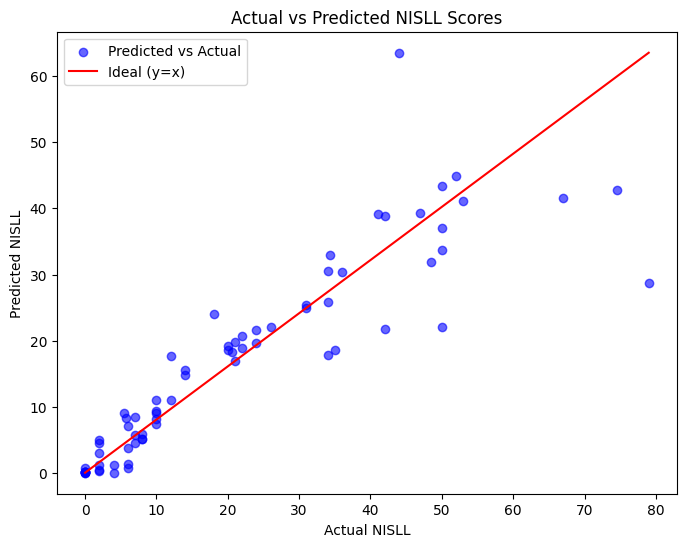

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot to visualize the comparison between predicted vs actual NISLL
plt.figure(figsize=(8, 6))

# Plotting actual vs predicted values
plt.scatter(y_test, predicted_nisll, alpha=0.6, color='blue', label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(predicted_nisll), max(predicted_nisll)], color="red", label="Ideal (y=x)")

# Labels and title
plt.title("Actual vs Predicted NISLL Scores")
plt.xlabel("Actual NISLL")
plt.ylabel("Predicted NISLL")
plt.legend()

# Show the plot
plt.show()

In [128]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your model is already trained and ready to make predictions

# Get historical data and predictions
predictions = []

for patient in df["Patient"].unique():
    # Filter the patient's data from the original DataFrame
    patient_data = df[df["Patient"] == patient].sort_values("Visite_date")

    # If the patient has data, make the prediction for the next visit
    if len(patient_data) > 1:  # Ensure there is at least one visit
        # Historical data (up to the last visit)
        historical_data = patient_data[["Visite_date", "NISLL"] + features].copy()

        # Get the last visit for the patient
        last_visit_data = patient_data.iloc[-1]

        # Make a prediction for the next visit using the model
        # (Assuming you have a method like model.predict() to get the prediction)
        next_visit_prediction = model.predict(np.array(np.concatenate([last_visit_data[features].values, [last_visit_data['NISLL']]]), dtype=np.float32).reshape(1, 1, -1))[0]

        predictions.append(next_visit_prediction)


1/1 [==============================] - 0s 21ms/step


In [129]:
# Convert predictions list to DataFrame
predictions_df = pd.DataFrame(predictions, columns=["Predicted_NISLL"])
print(predictions_df)

    Predicted_NISLL
0         15.940177
1         36.650059
2          0.237450
3          0.160139
4         21.194336
..              ...
79        15.086469
80        39.756710
81         9.337008
82        17.148012
83         9.486420

[84 rows x 1 columns]


In [67]:
predictions_df['Predicted_NISLL'] = predictions_df['Predicted_NISLL'].apply(lambda x: 0 if x <= 0 else x)
print(predictions_df)

    Predicted_NISLL
0         15.912024
1         41.419407
2          0.105429
3          0.000000
4         21.821470
..              ...
79        16.188848
80        44.959923
81         8.260207
82        18.288797
83         7.098695

[84 rows x 1 columns]


In [130]:

# Assuming predictions_df contains the predicted NISLL values for each patient in order
# Initialize an empty list to store the combined data for each patient
combined_data = []

# Loop through each patient in df and get the corresponding prediction from predictions_df
for i, patient in enumerate(df["Patient"].unique()):
    # Filter the patient's historical data from the original DataFrame
    patient_data = df[df["Patient"] == patient].sort_values("Visite_date")

    # Retrieve the predicted NISLL for this patient from predictions_df (same order)
    predicted_nisll = predictions_df.iloc[i]['Predicted_NISLL']

    # Create a new DataFrame with historical NISLL data
    historical_data = patient_data[["Patient", "Visite_date", "NISLL"]].copy()

    # Append the predicted NISLL as the next visit for the patient
    # Add the predicted value as a new row (assuming 30 days after the last visit)
    next_visit_data = pd.DataFrame({
         "Patient": [patient],
        "Visite_date": [patient_data["Visite_date"].max() +180],  # Assuming the next visit is 30 days later
        "NISLL": [predicted_nisll]
    })

    # Append the next predicted visit to the historical data
    combined_patient_data = pd.concat([historical_data, next_visit_data], ignore_index=True)

    # Add the combined data for this patient to the list
    combined_data.append(combined_patient_data)

# Combine all patient data into a final DataFrame
final_df = pd.concat(combined_data, ignore_index=True)

# Check the final result
print(final_df.head())


  Patient  Visite_date      NISLL
0  C1S001            0  12.847826
1  C1S001          189   5.503235
2  C1S001          373  23.000000
3  C1S001          530  11.286869
4  C1S001          719   5.489362


In [72]:
final_df

,Patient,Visite_date,NISLL
0,C1S001,0,12.847826
1,C1S001,189,5.503235
2,C1S001,373,23.000000
3,C1S001,530,11.286869
4,C1S001,719,5.489362
...,...,...,...
521,C1S090,364,18.288797
522,C1S091,0,31.255567
523,C1S091,800,17.587677
524,C1S091,1717,8.000000


In [73]:
final_df['Patient'].nunique()

84

In [131]:
final_df['NISLL'].max()

79.0

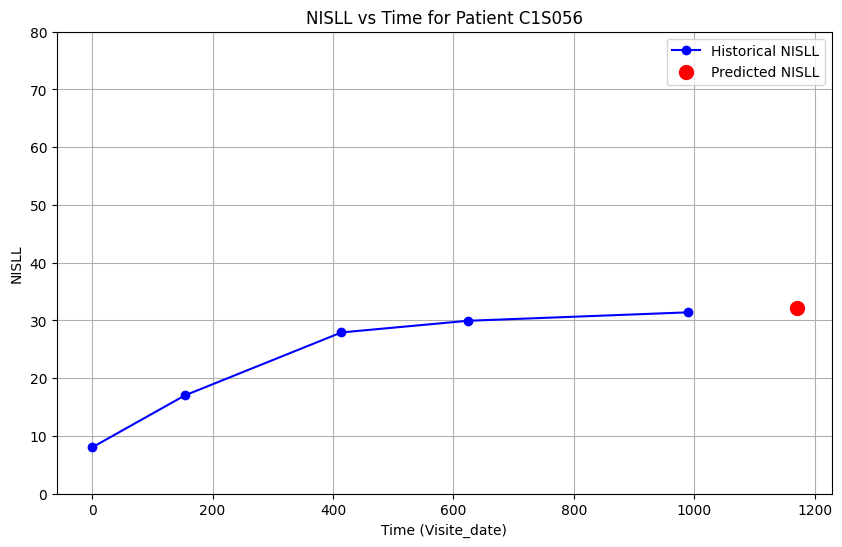

In [134]:


def plot_random_patient(final_df):
    # Step 1: Select a random patient
    random_patient = np.random.choice(final_df["Patient"].unique())
    
    # Step 2: Get the patient's data
    patient_data = final_df[final_df["Patient"] == random_patient]
    
    # Step 3: Separate historical data and predicted data
    historical_data = patient_data[:-1]  # All except the last row
    predicted_data = patient_data.iloc[-1]  # The last row (prediction)
    
    # Step 4: Plot the NISLL vs. time
    plt.figure(figsize=(10, 6))
    
    # Plot historical NISLL vs. Visite_date
    plt.plot(historical_data["Visite_date"], historical_data["NISLL"], label="Historical NISLL", color='b', marker='o')
    
    # Plot predicted NISLL with a different color
    plt.scatter(predicted_data["Visite_date"], predicted_data["NISLL"], color='r', label="Predicted NISLL", s=100, zorder=5)
    
    # Add labels and title
    plt.xlabel('Time (Visite_date)')
    plt.ylabel('NISLL')
    plt.title(f'NISLL vs Time for Patient {random_patient}')
    
    plt.ylim(bottom=0)
    plt.ylim(top=80)
    # Show legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()

# Call the function
plot_random_patient(final_df)


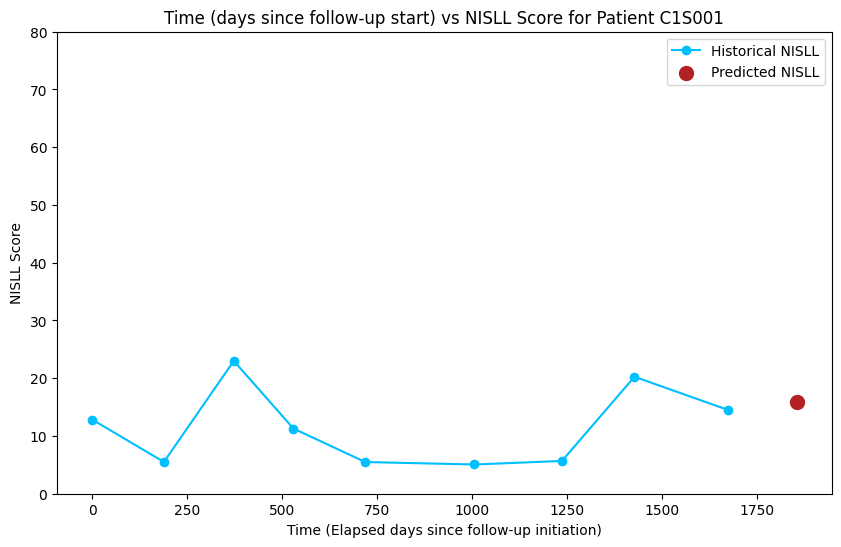

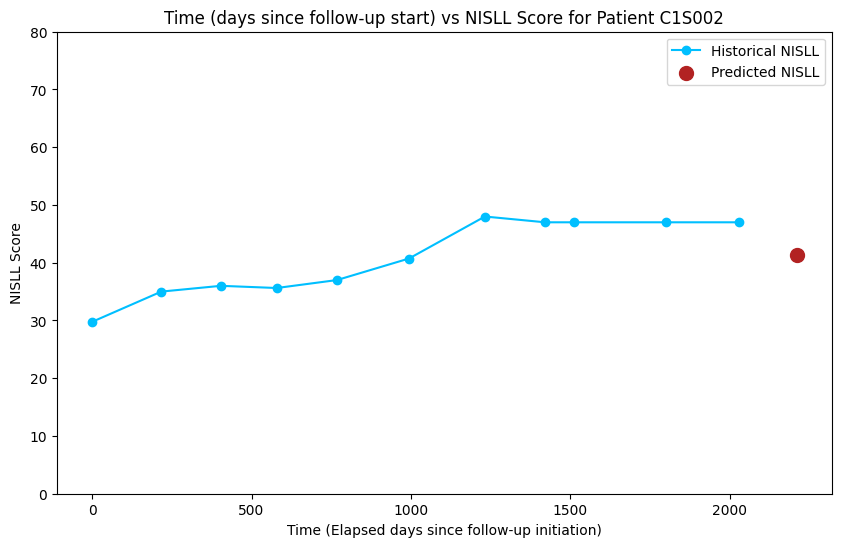

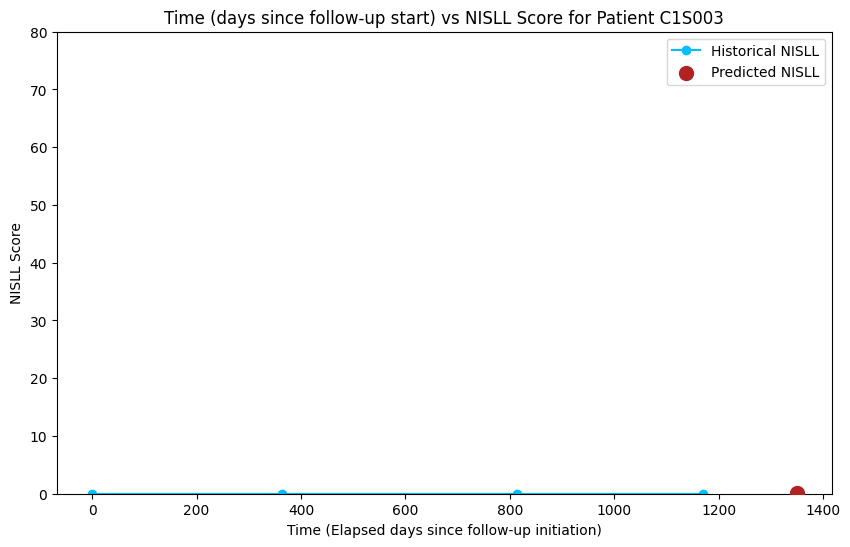

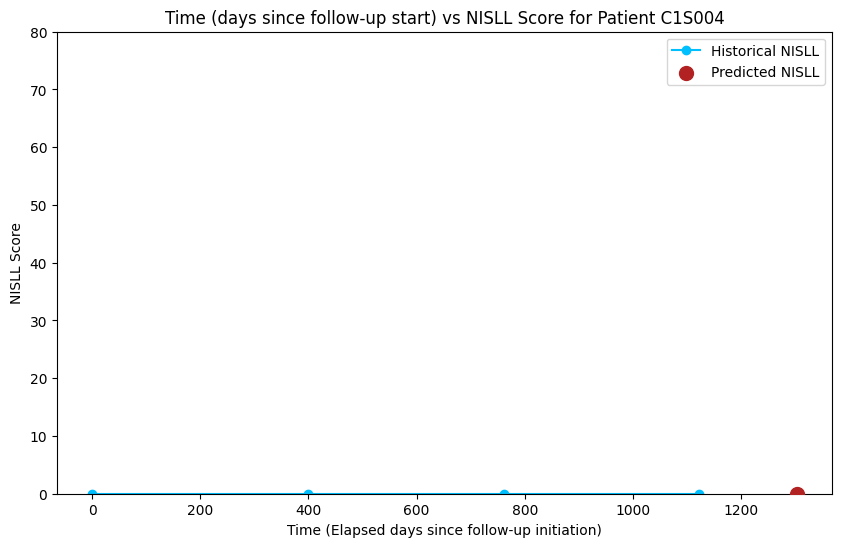

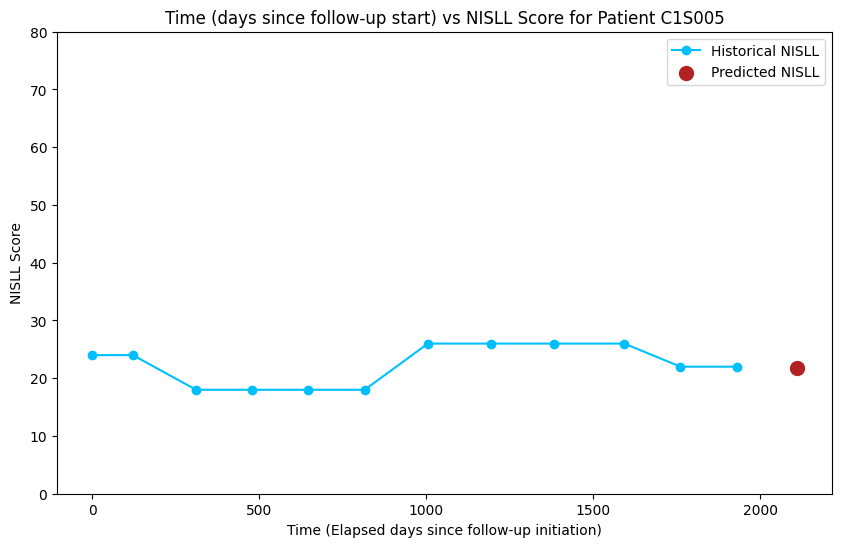

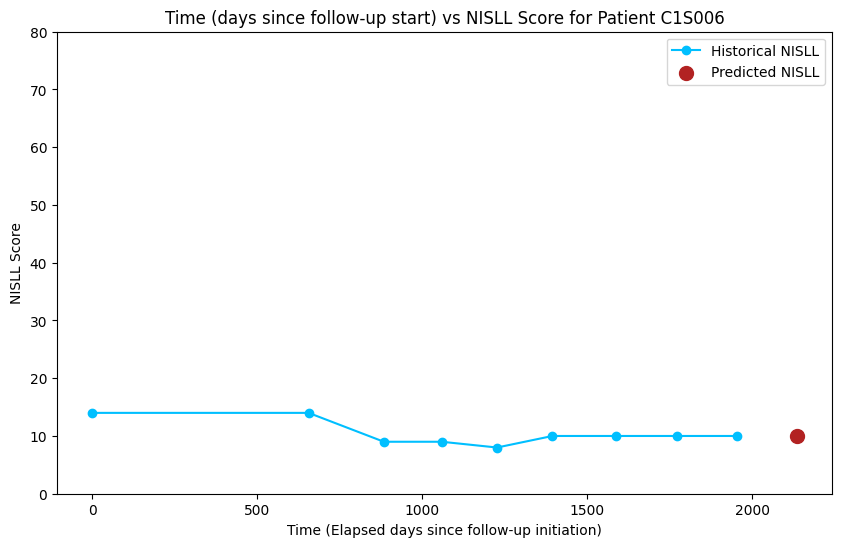

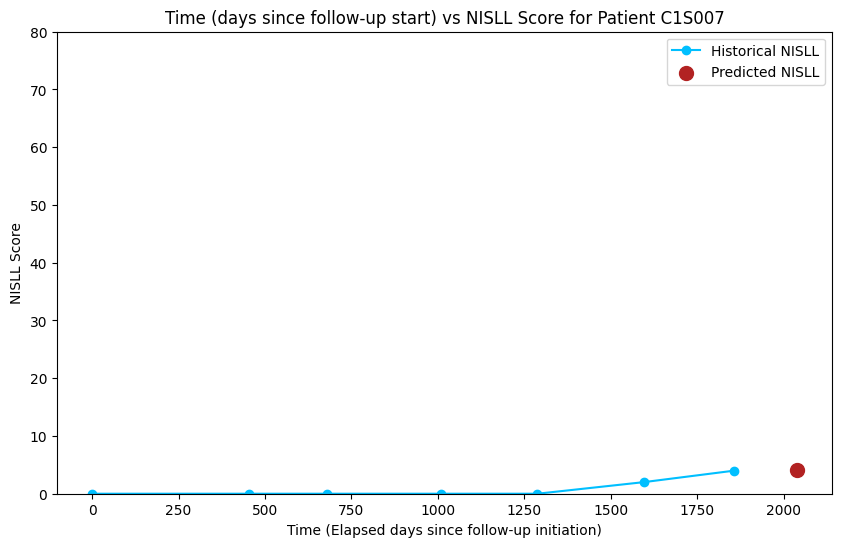

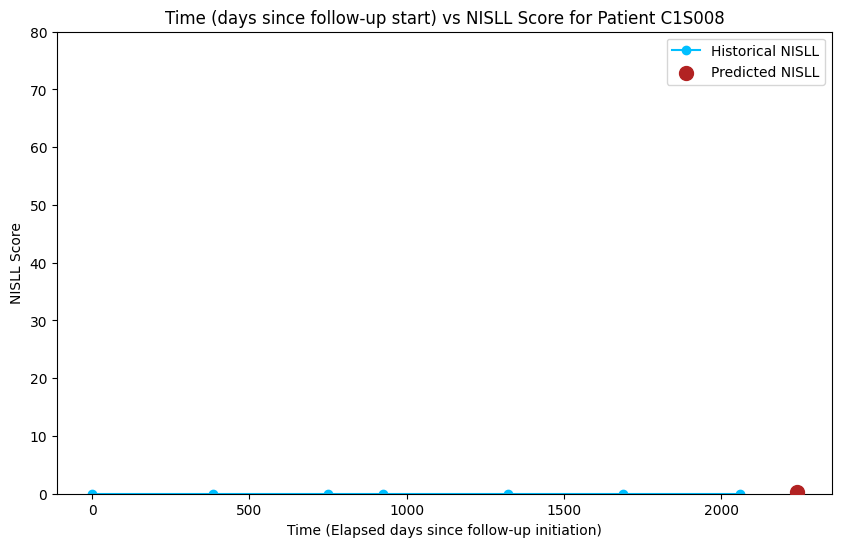

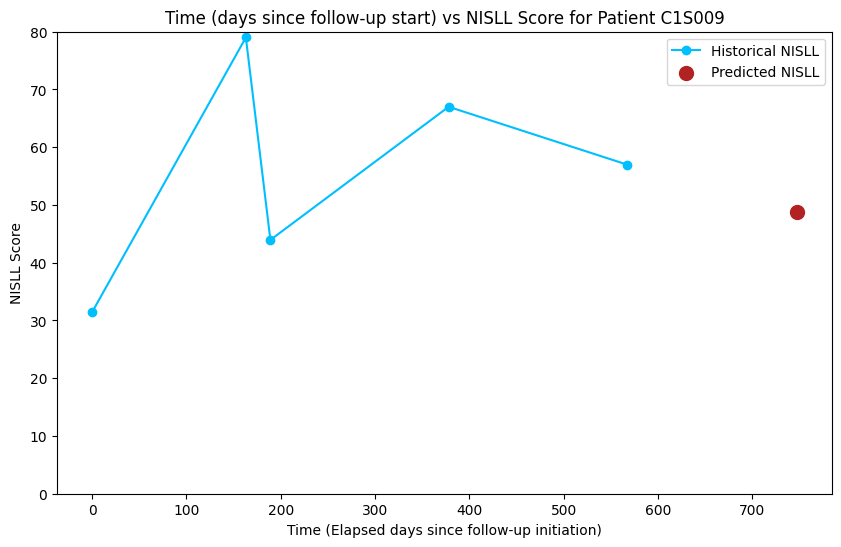

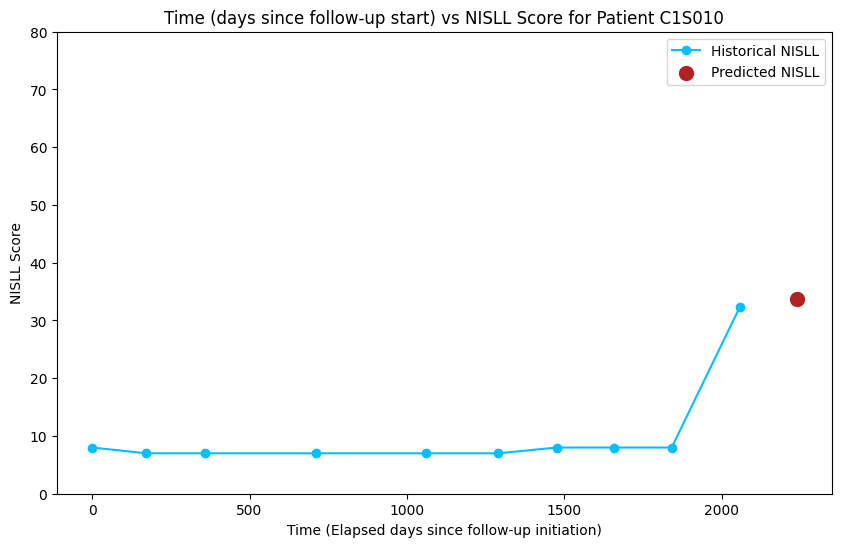

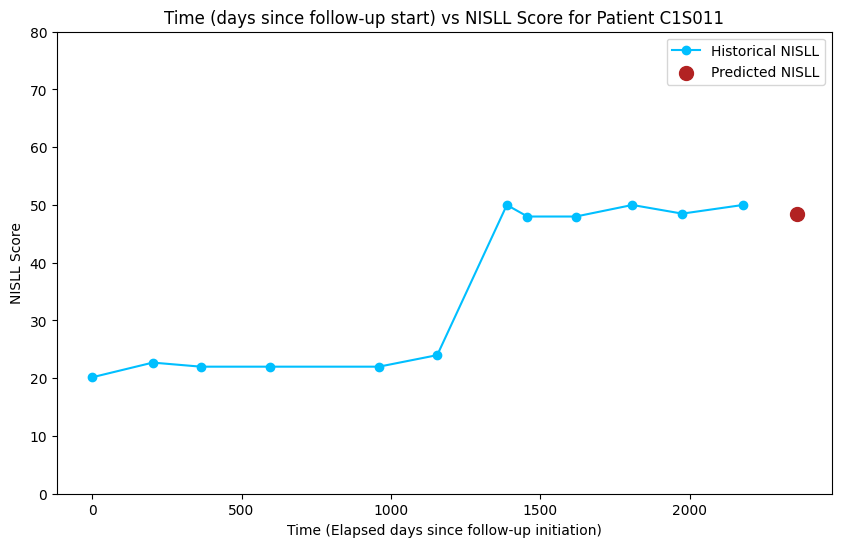

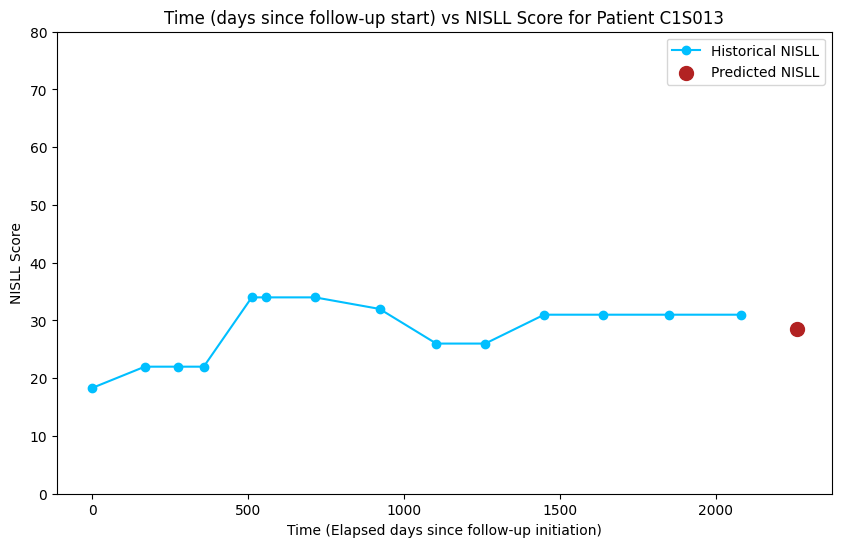

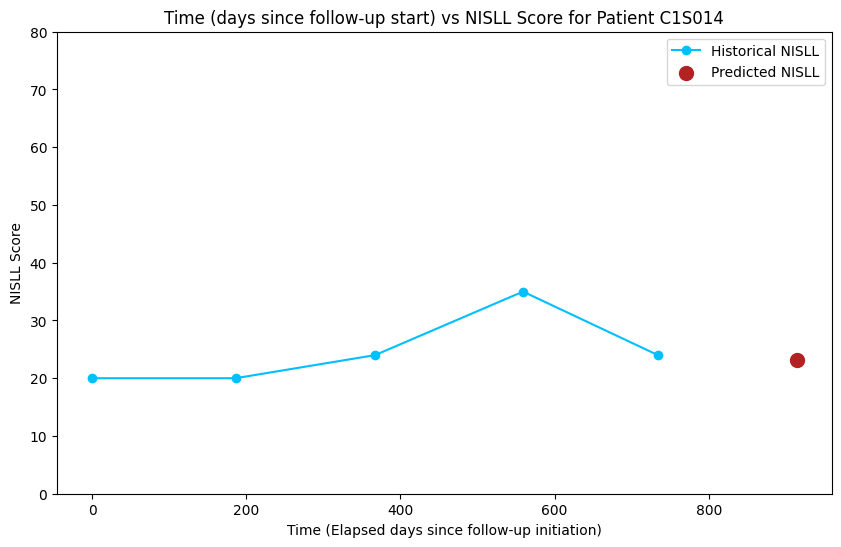

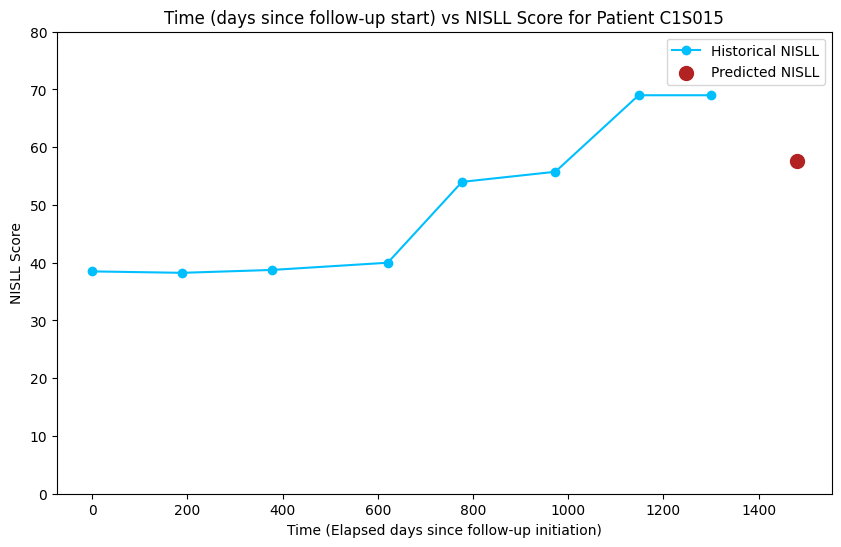

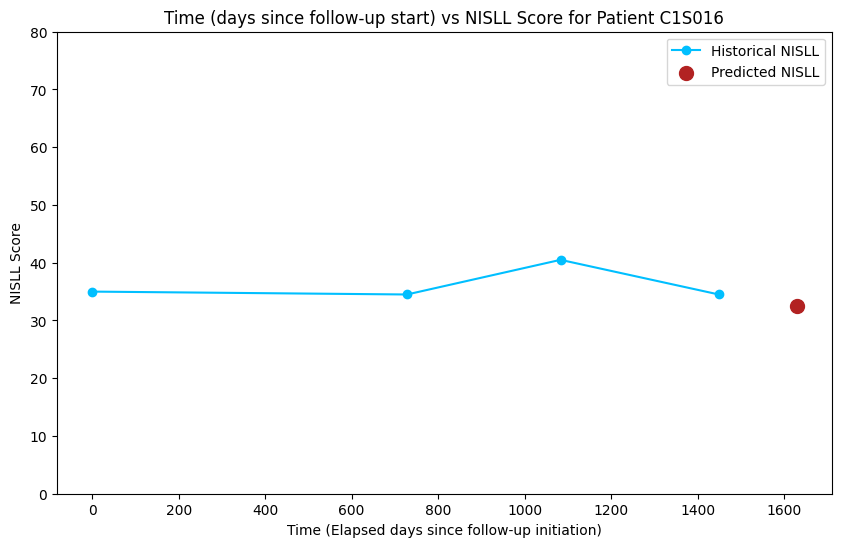

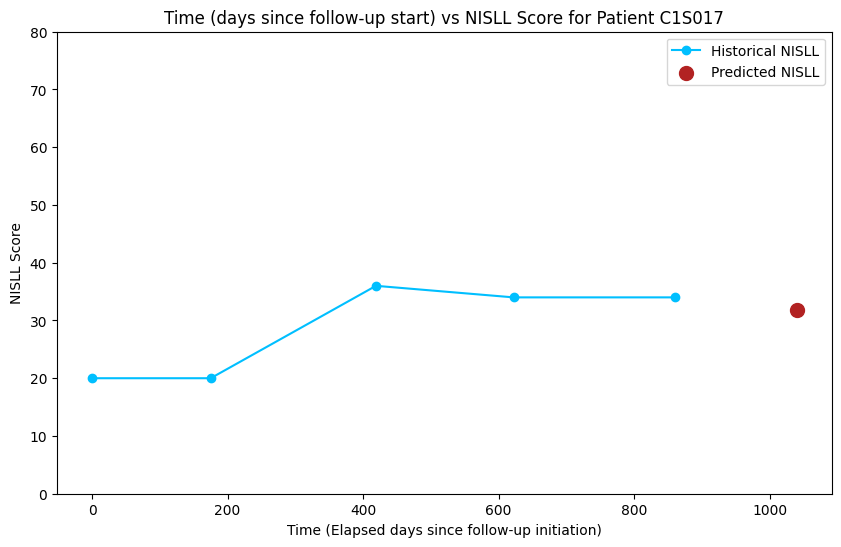

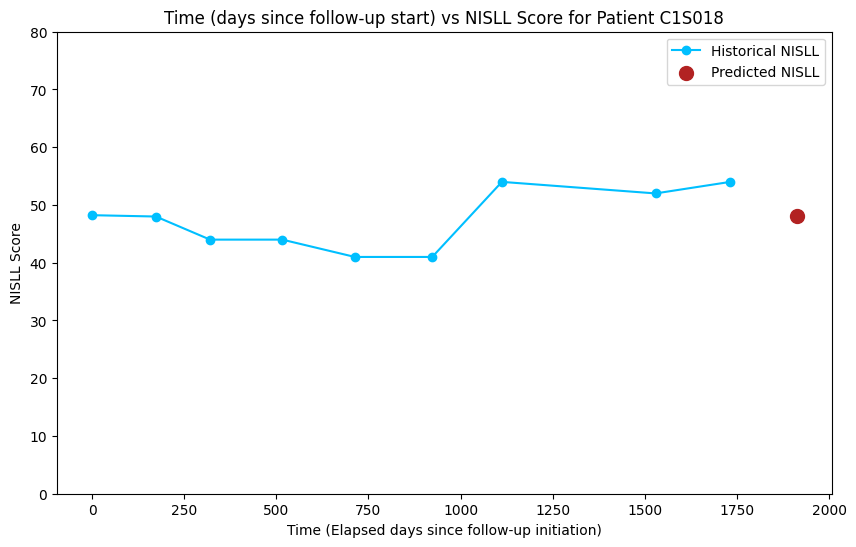

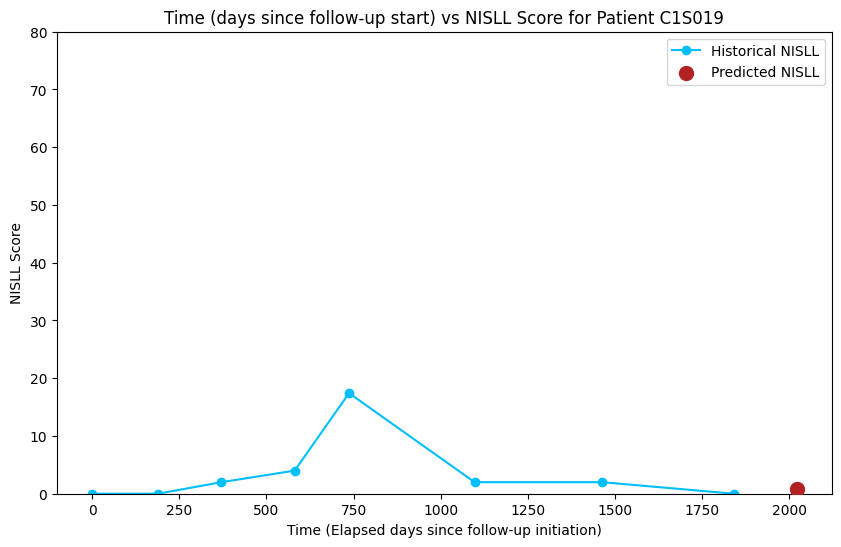

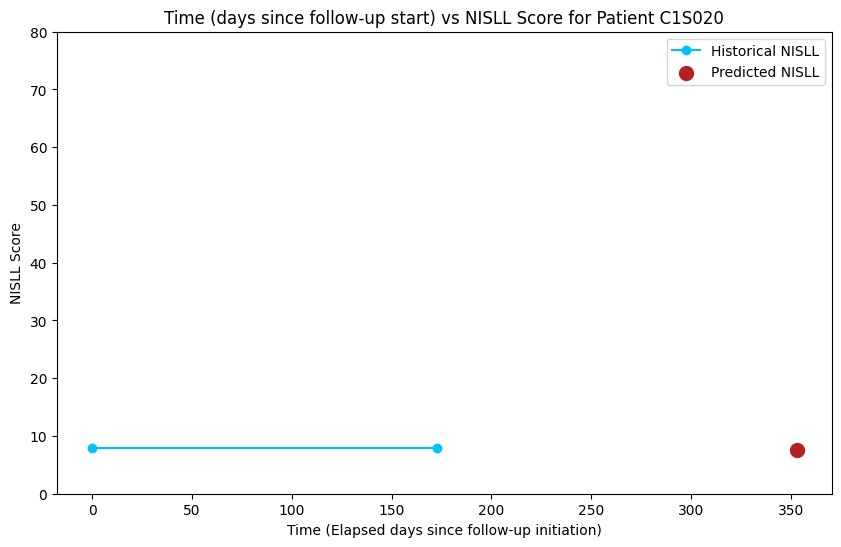

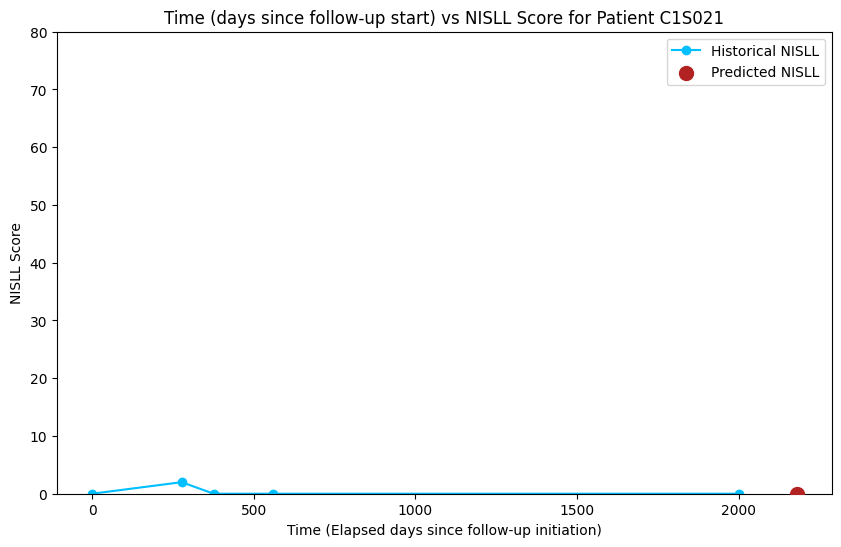

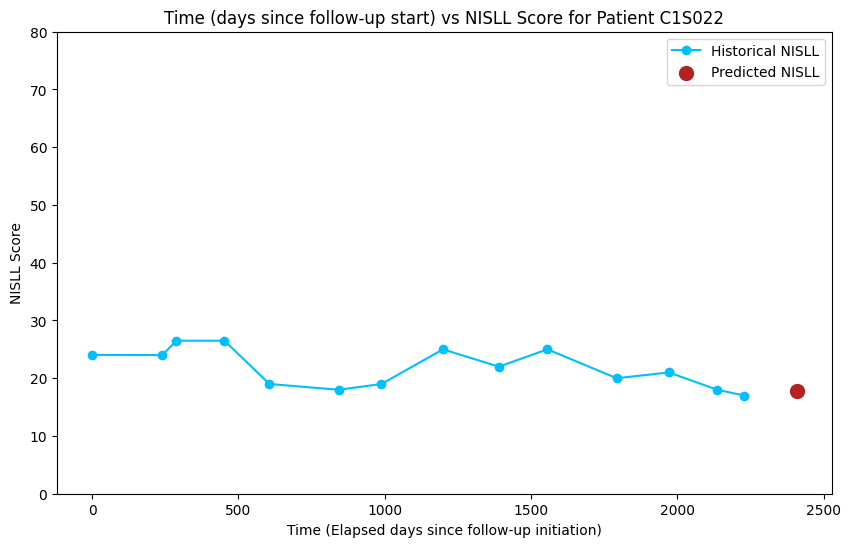

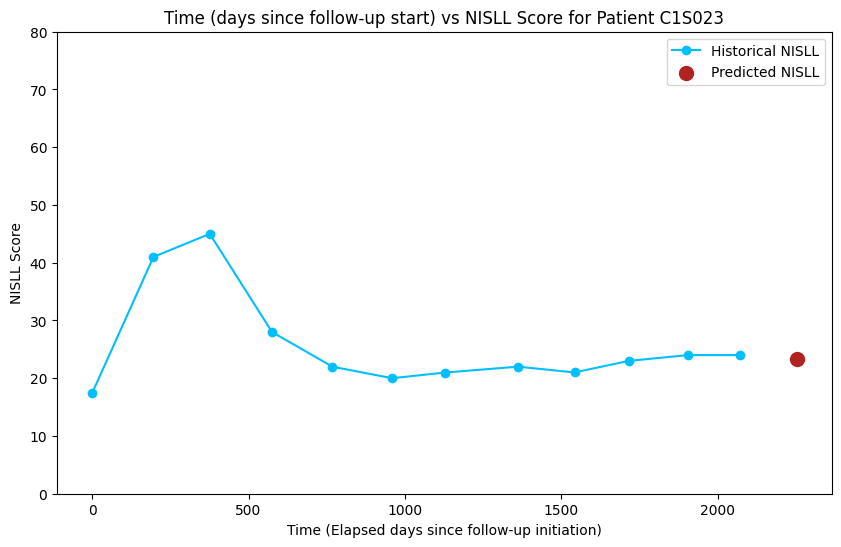

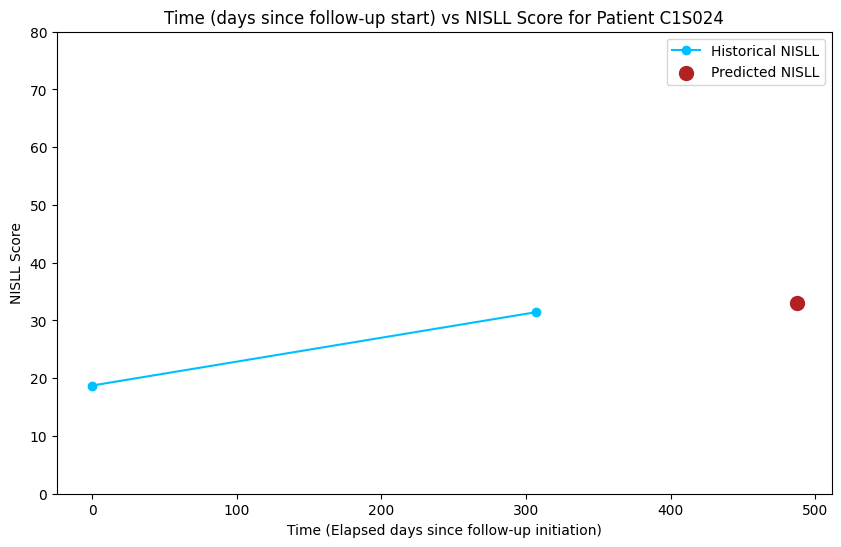

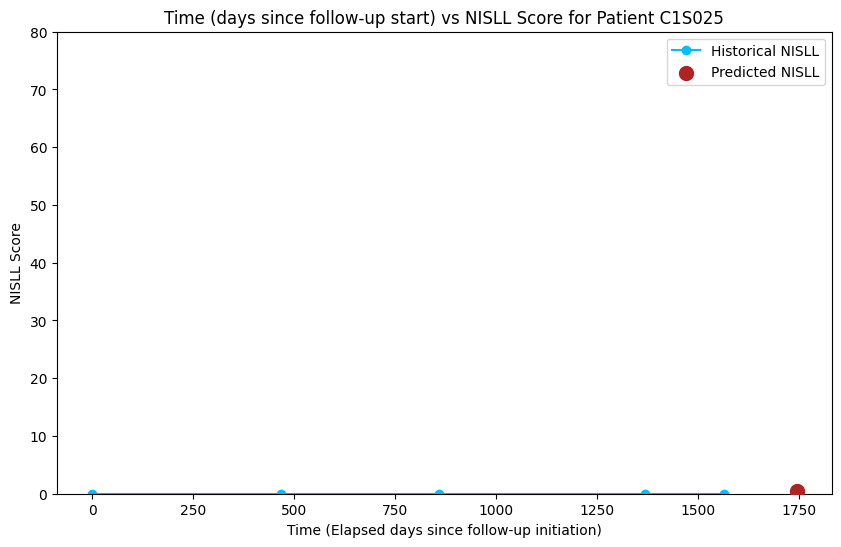

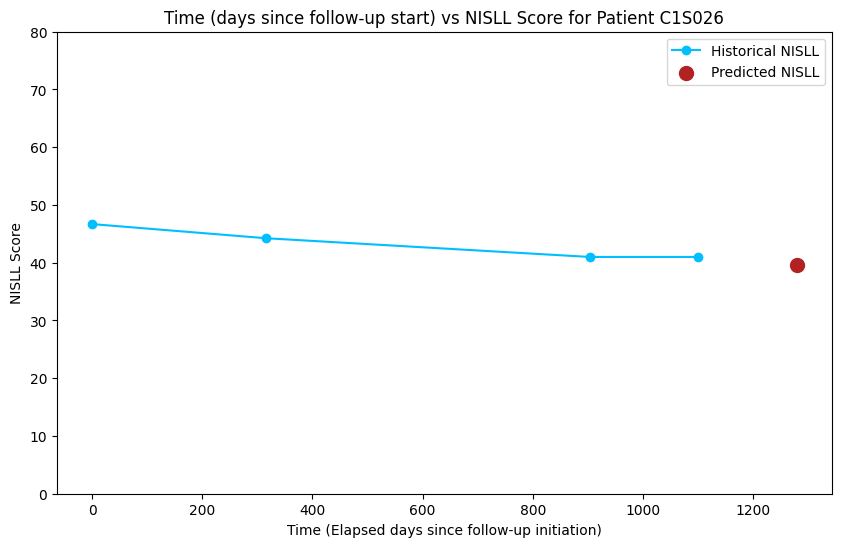

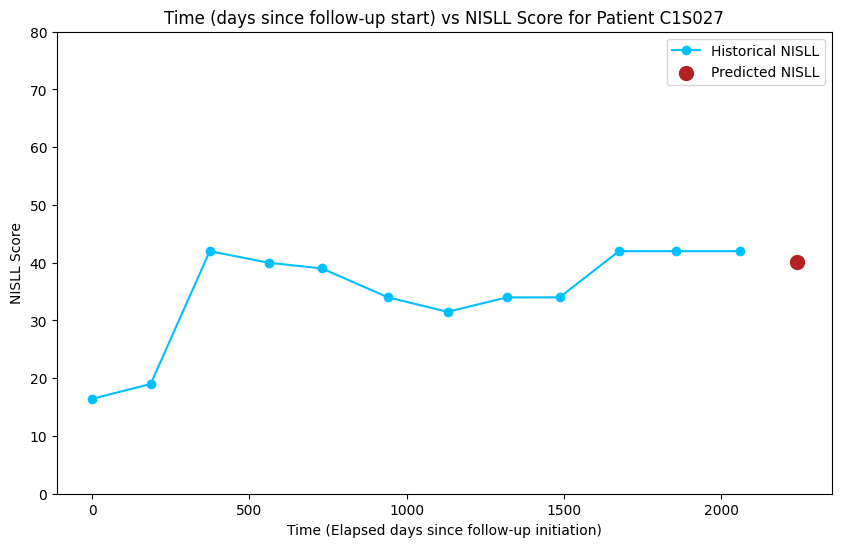

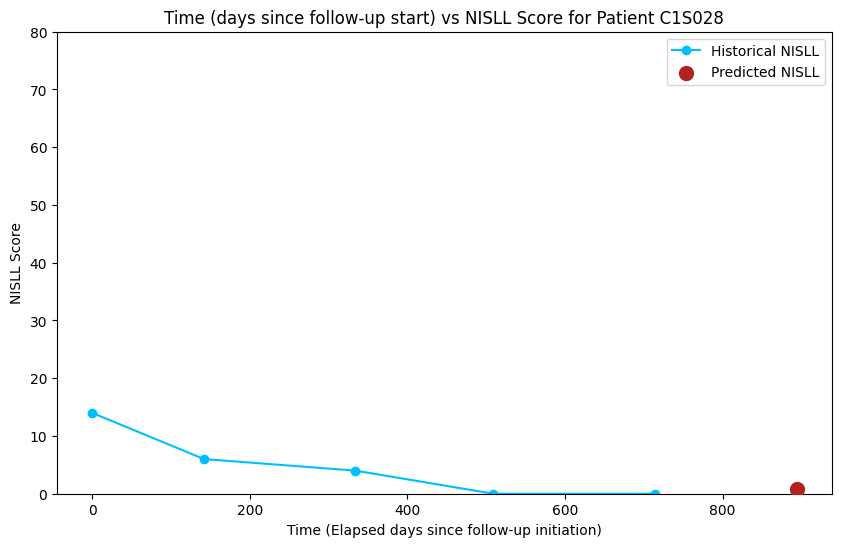

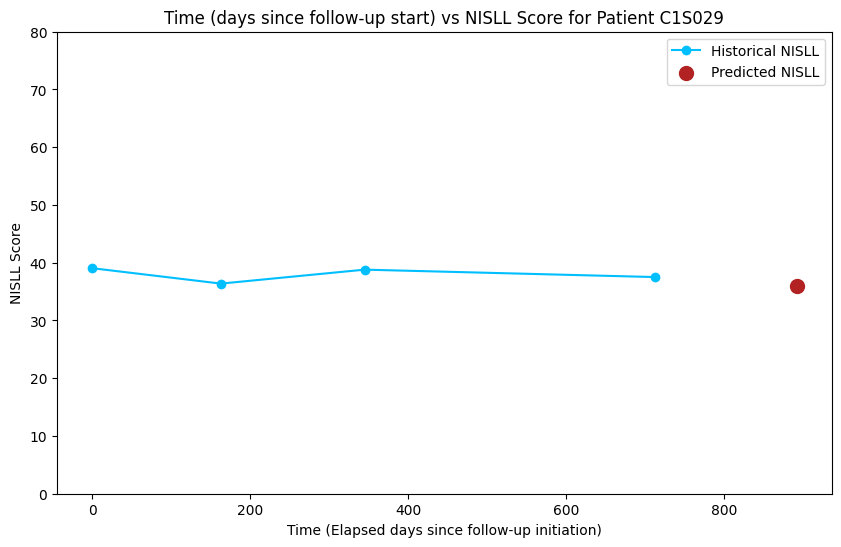

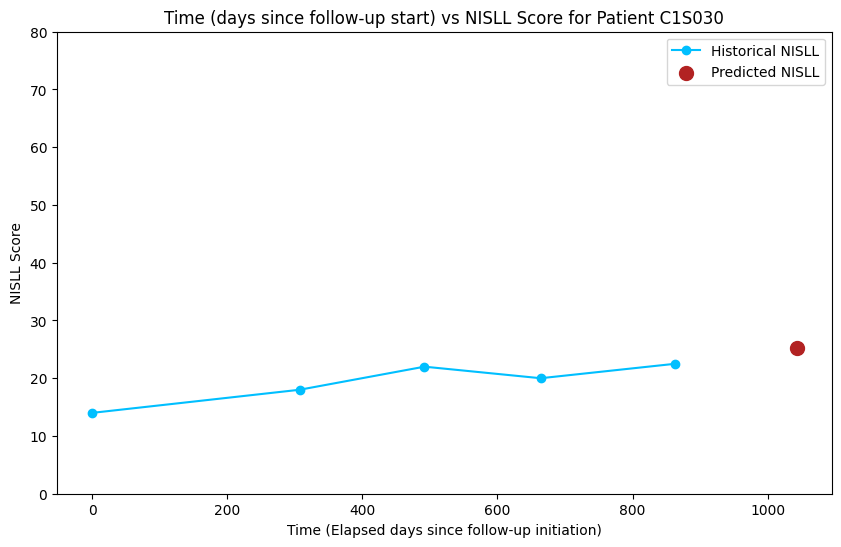

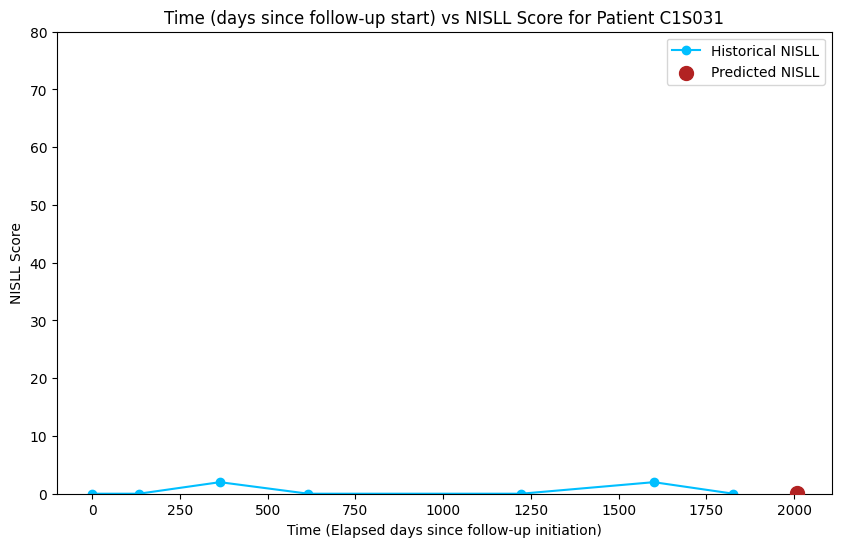

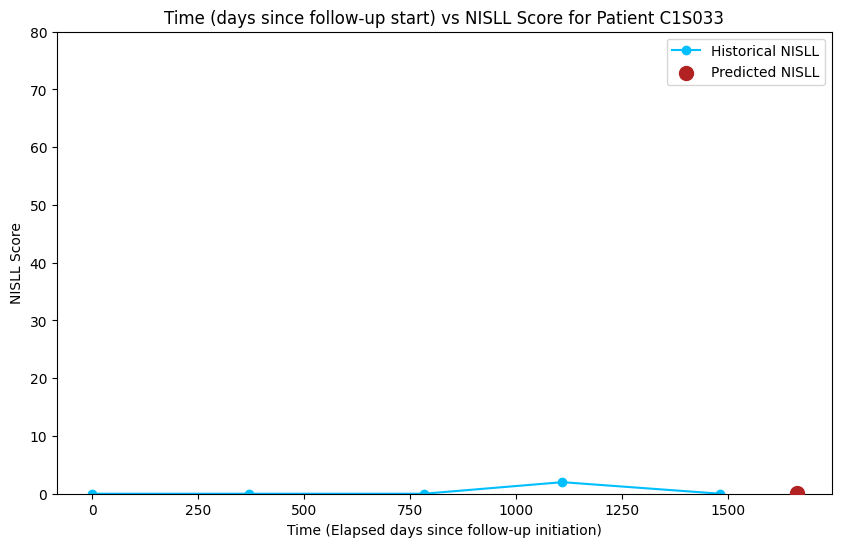

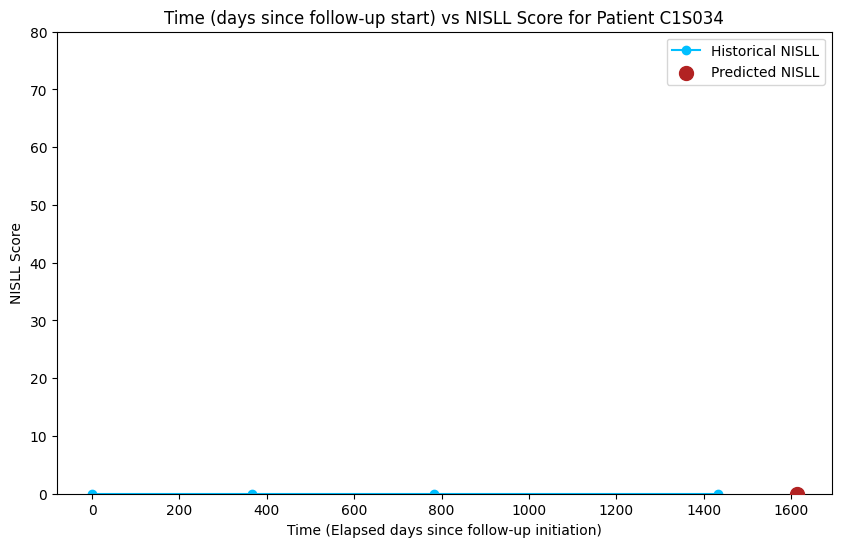

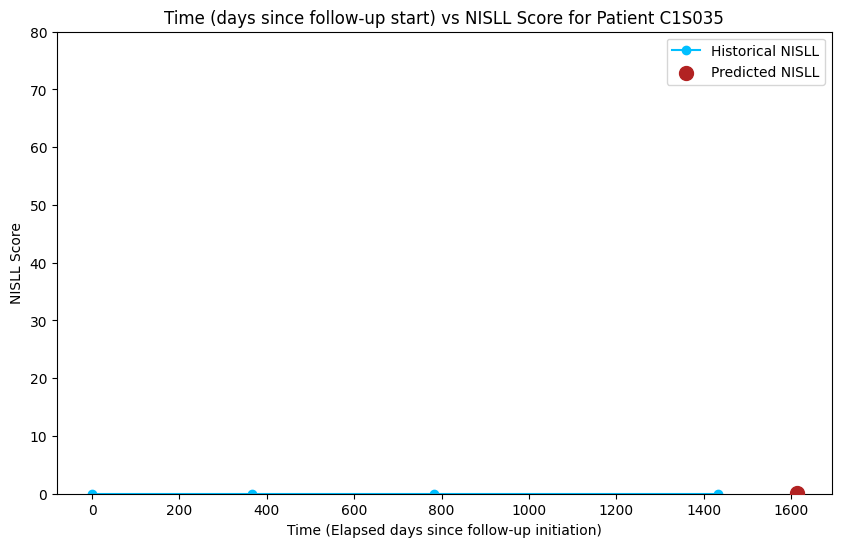

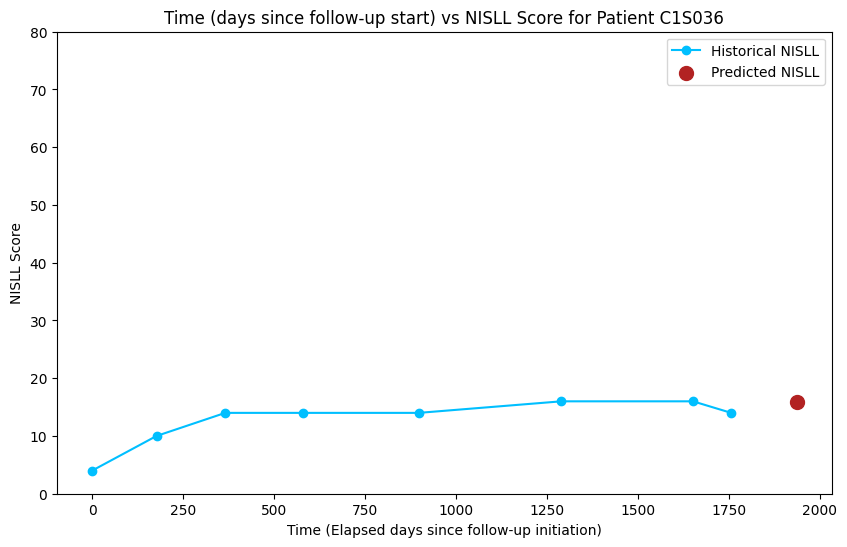

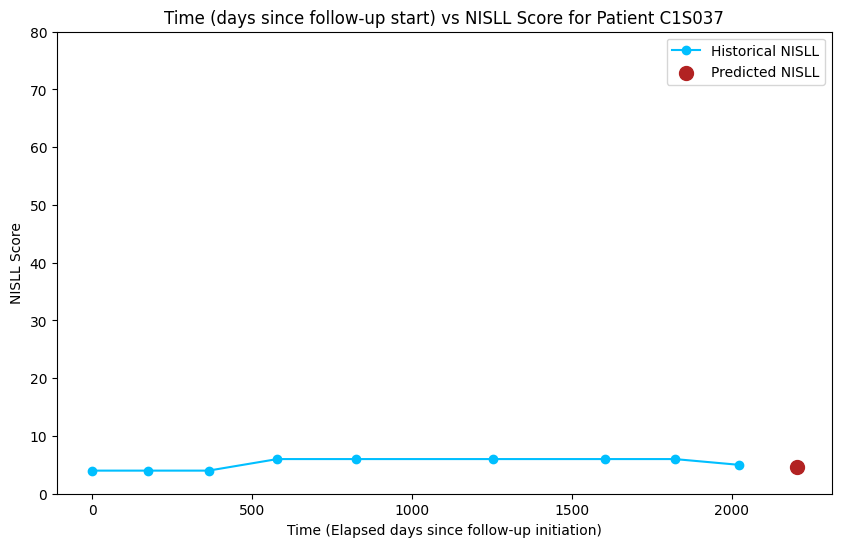

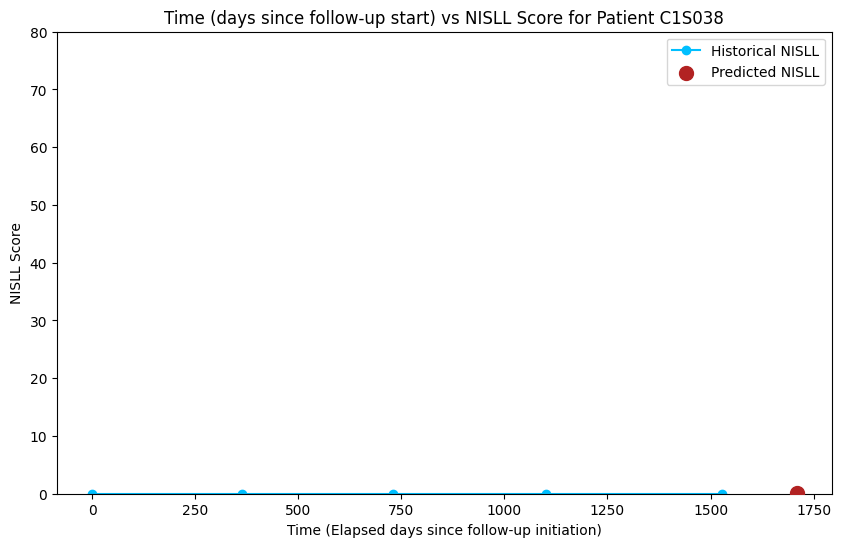

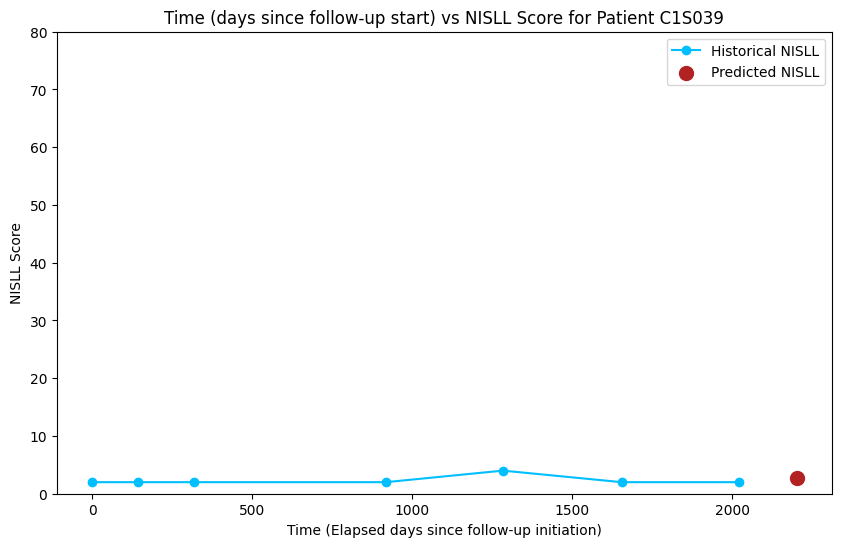

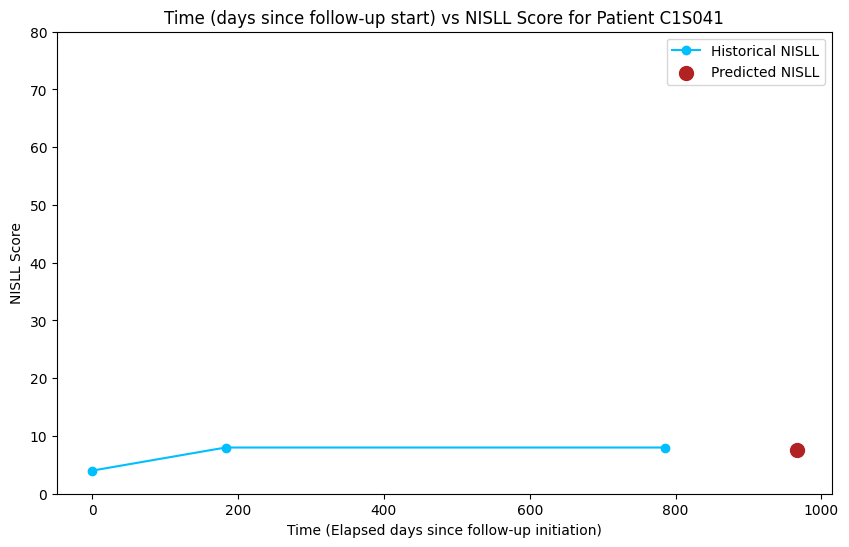

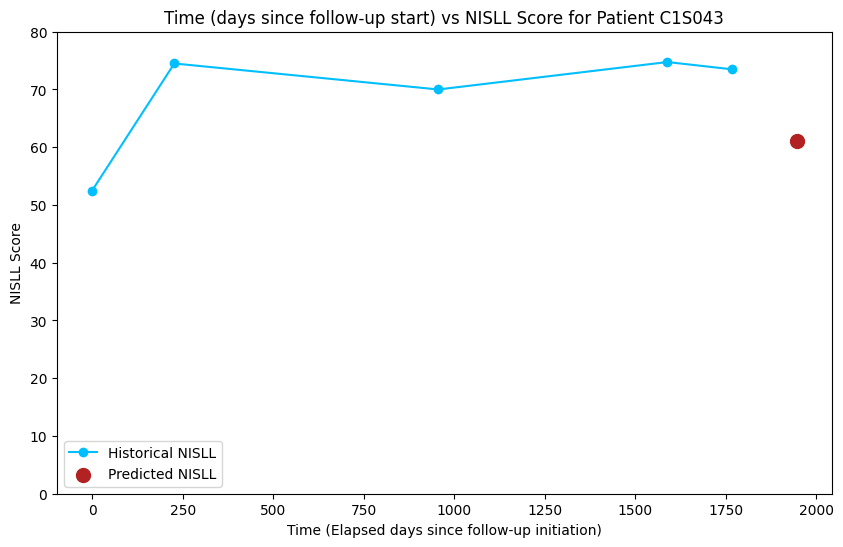

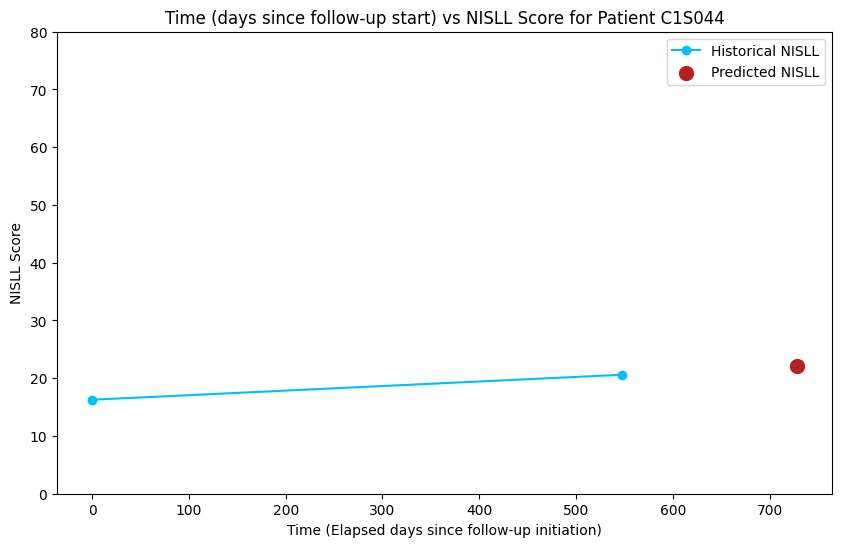

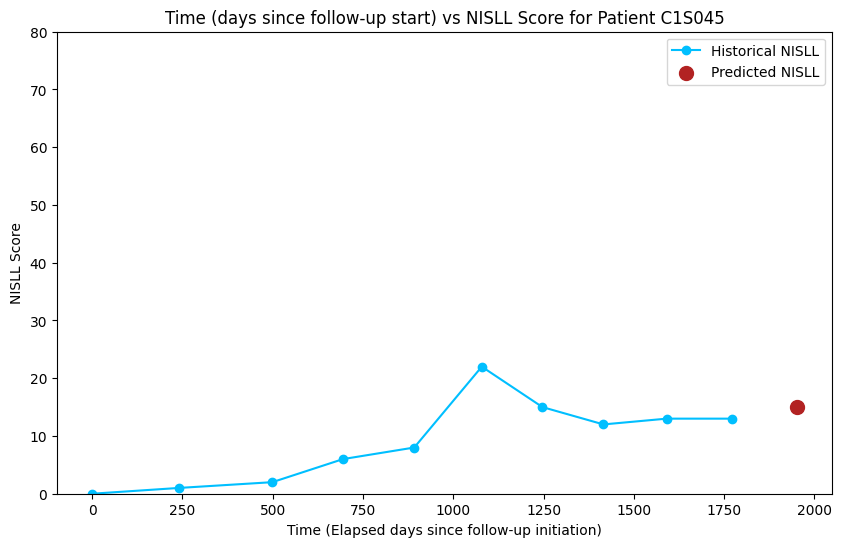

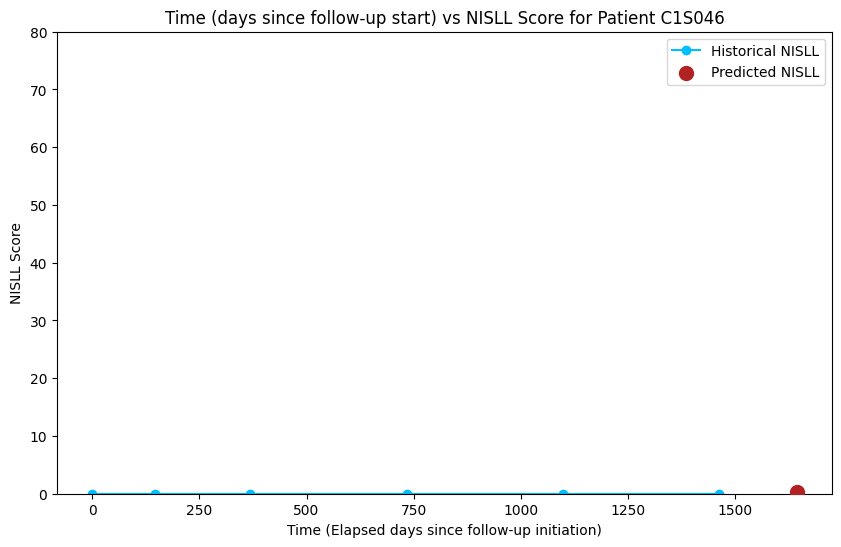

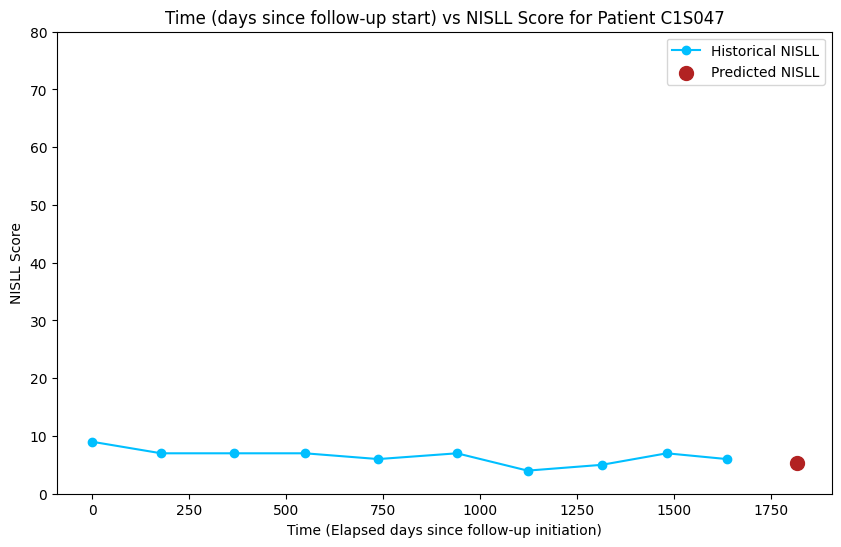

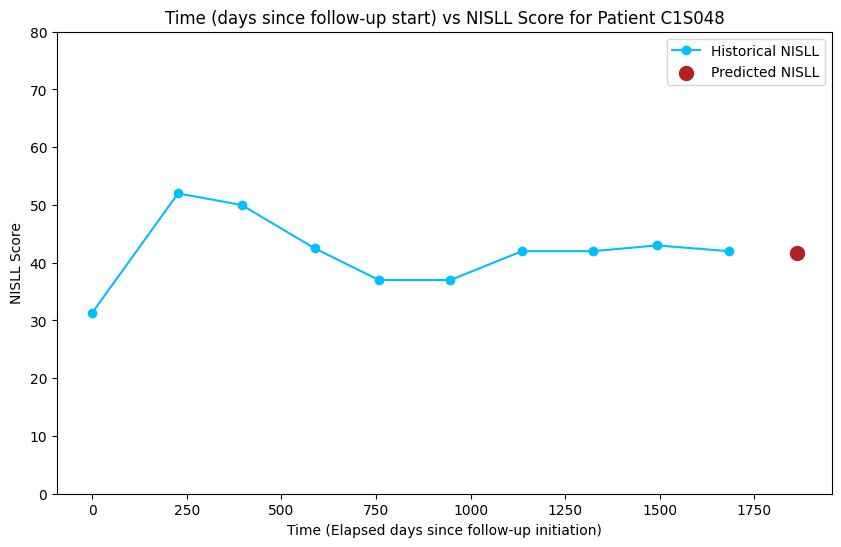

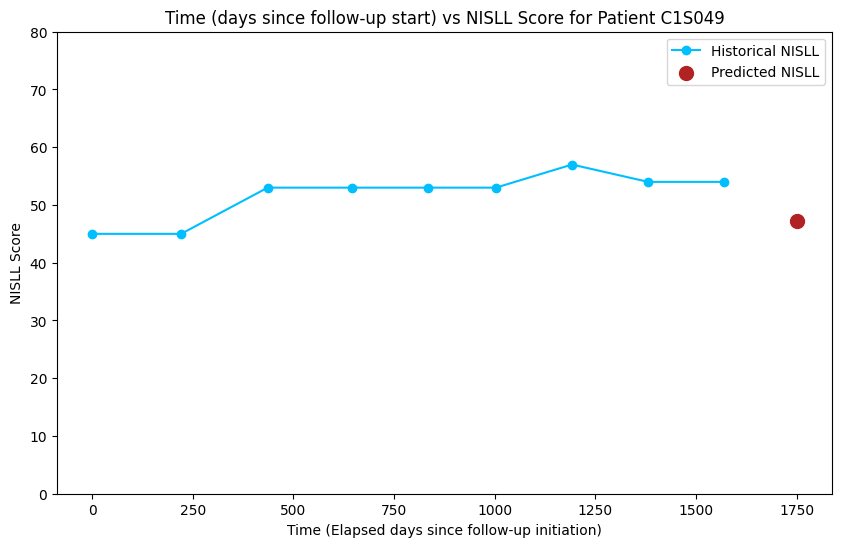

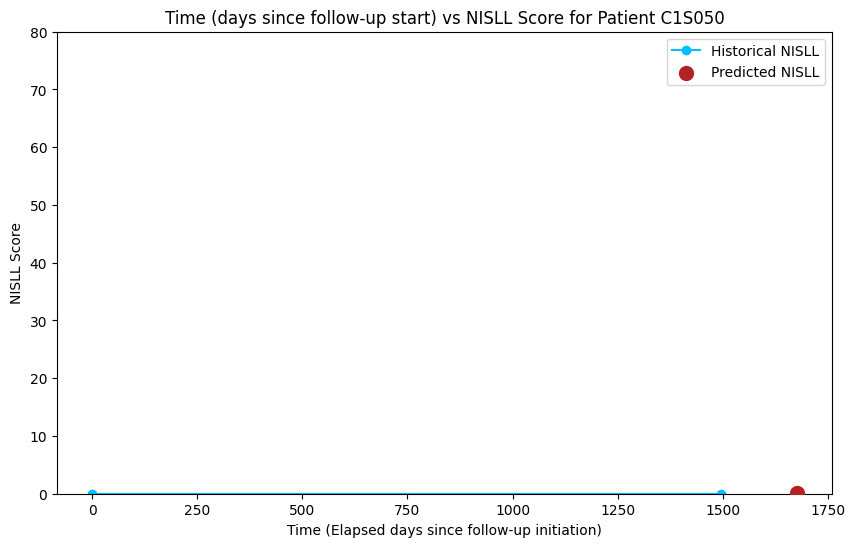

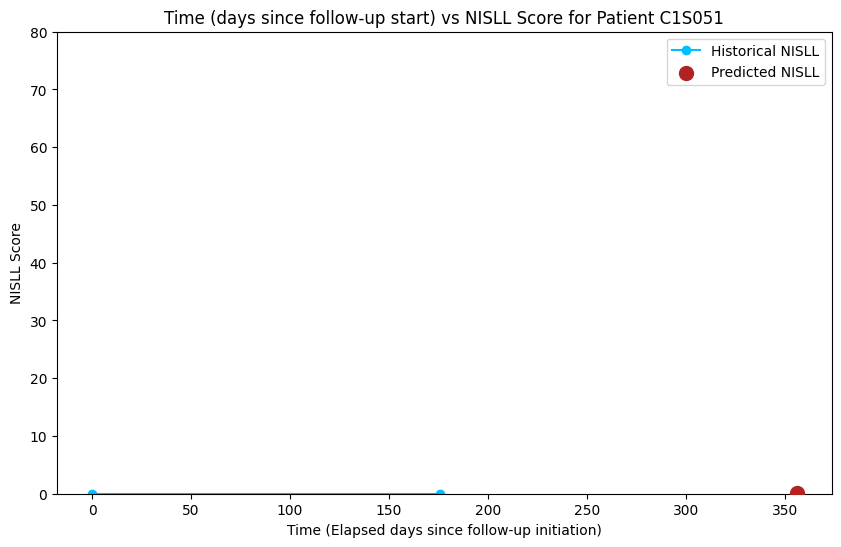

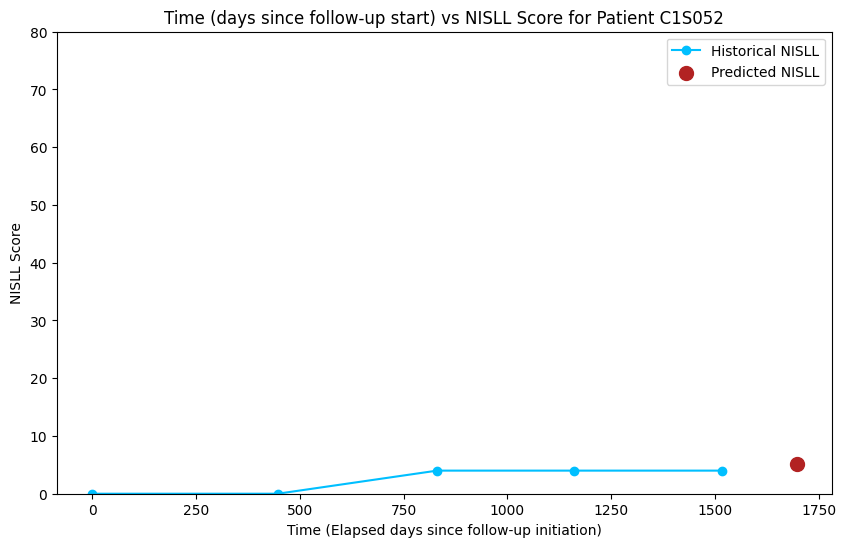

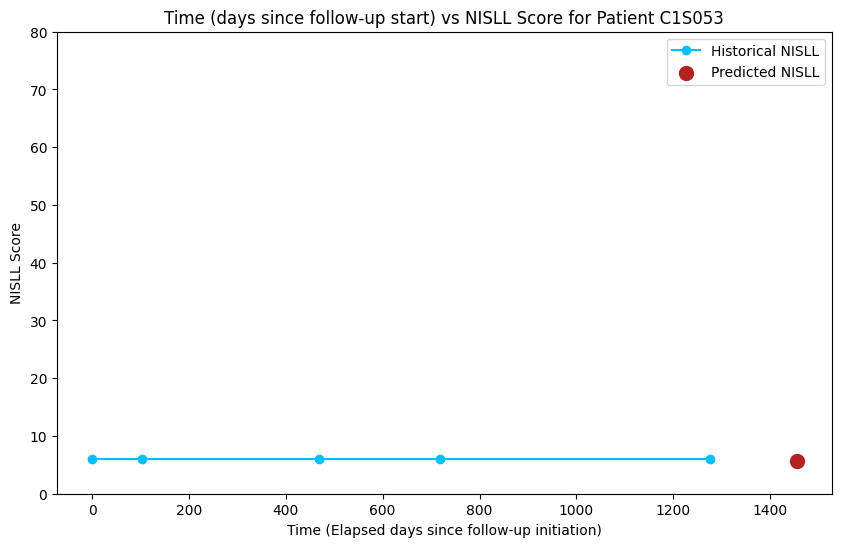

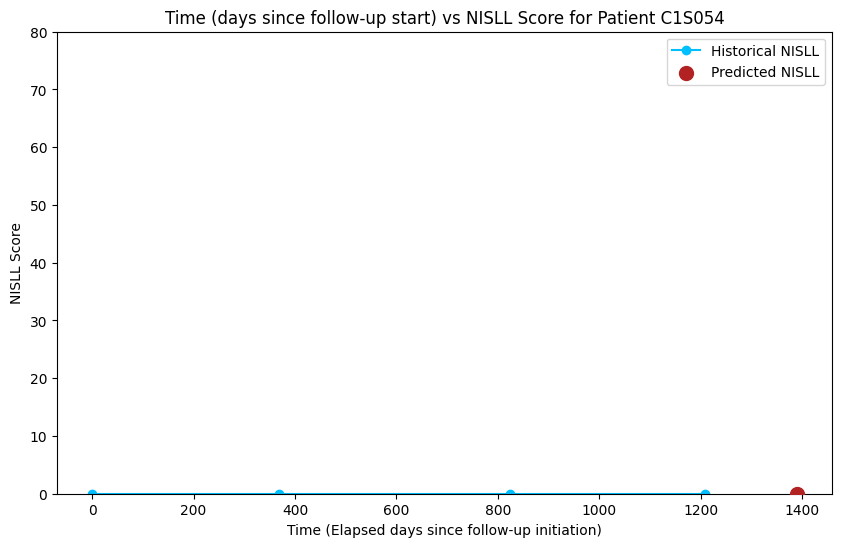

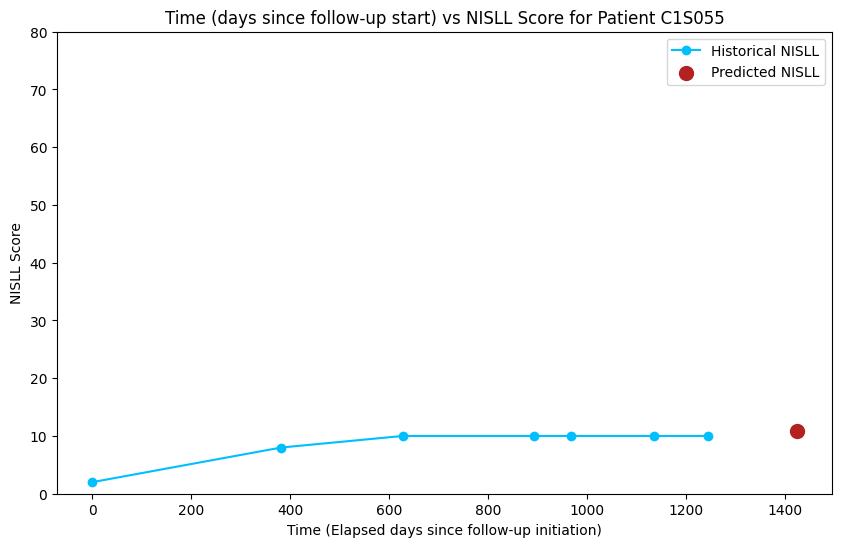

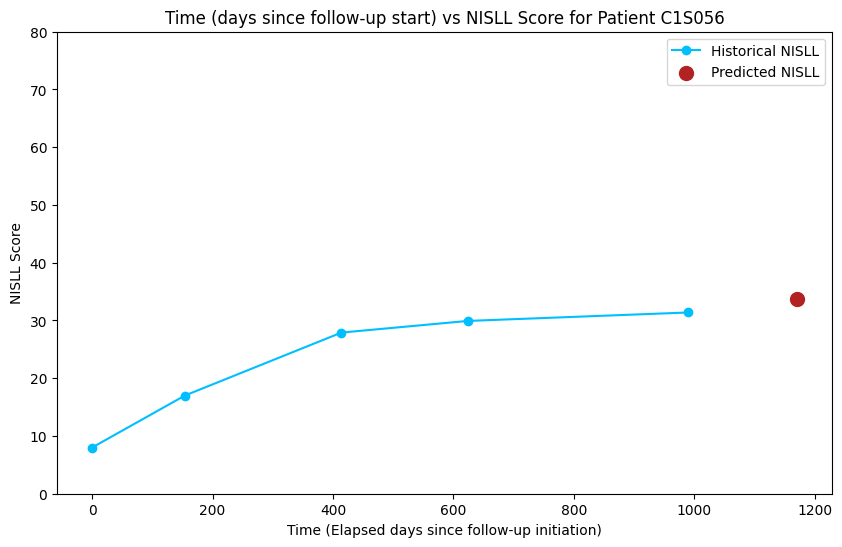

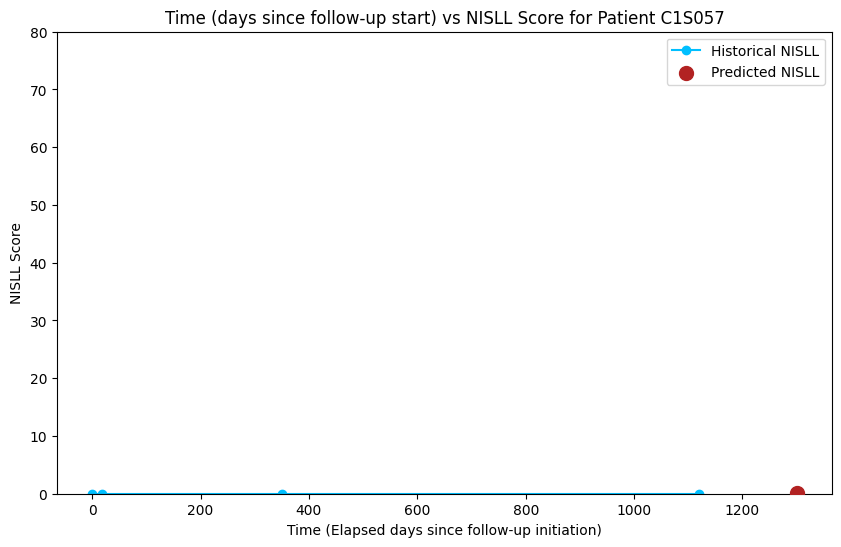

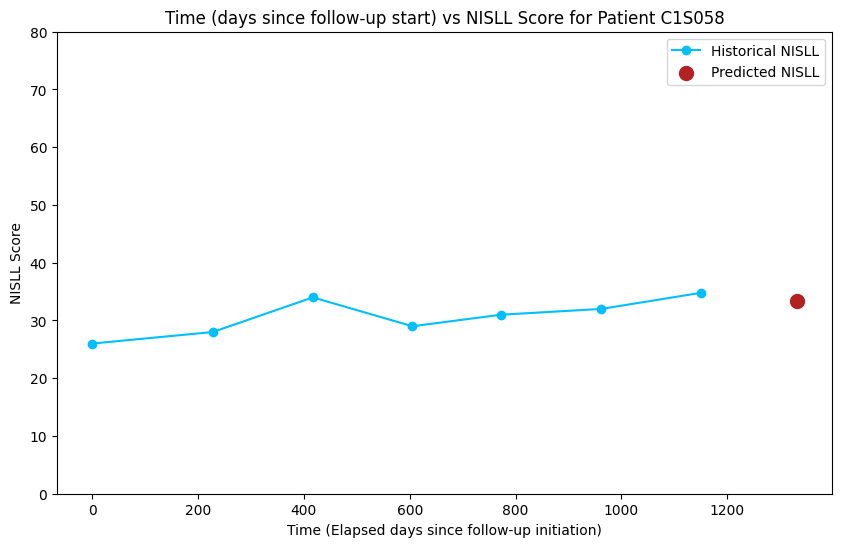

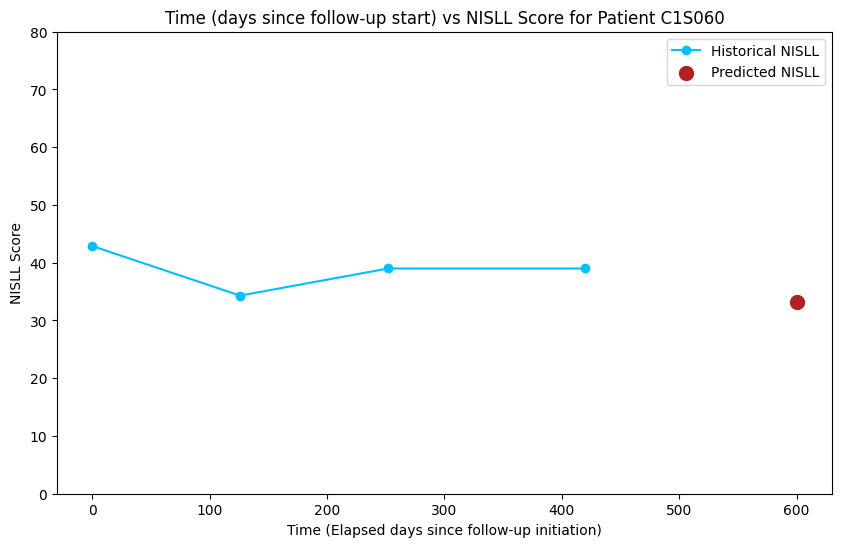

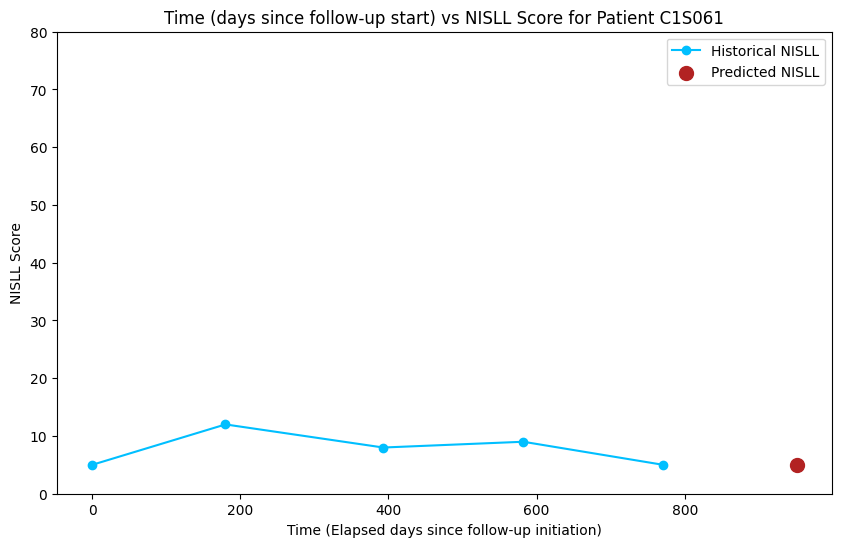

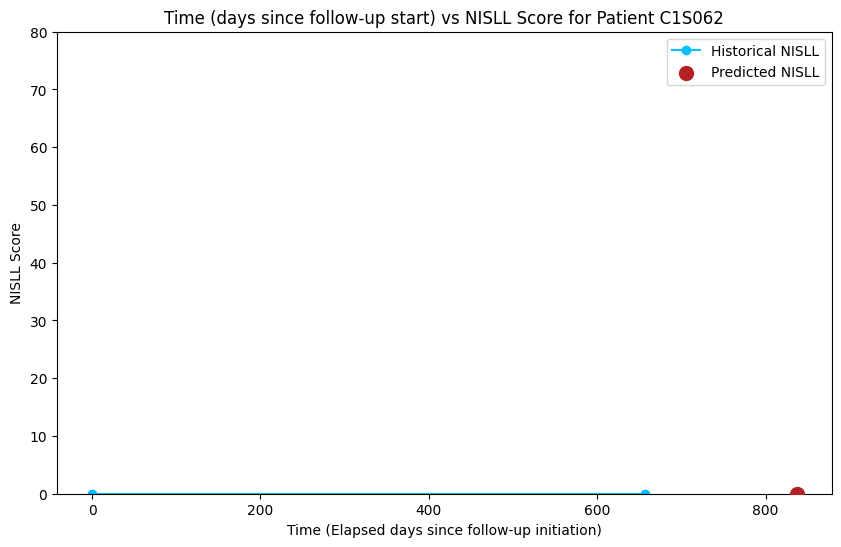

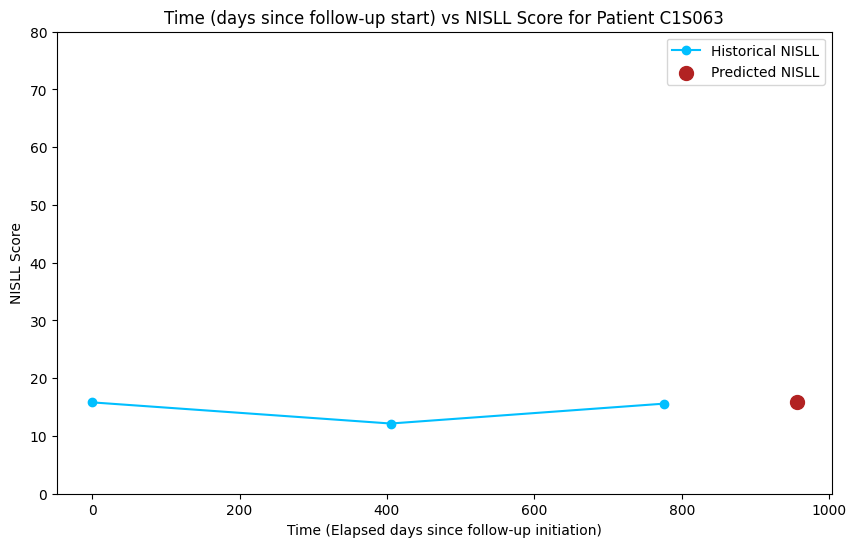

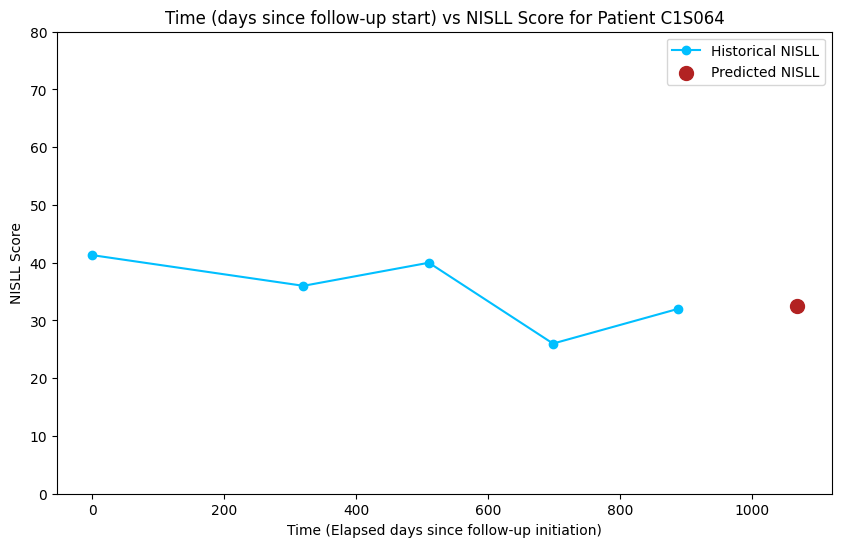

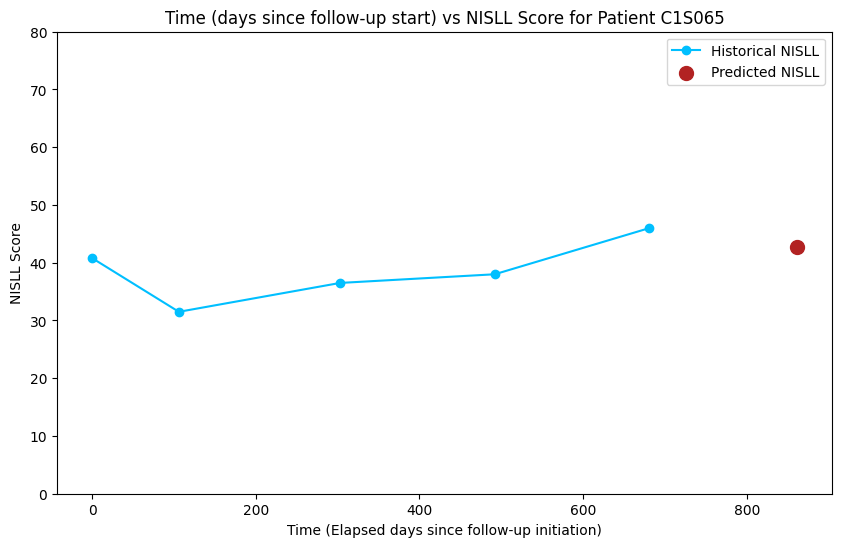

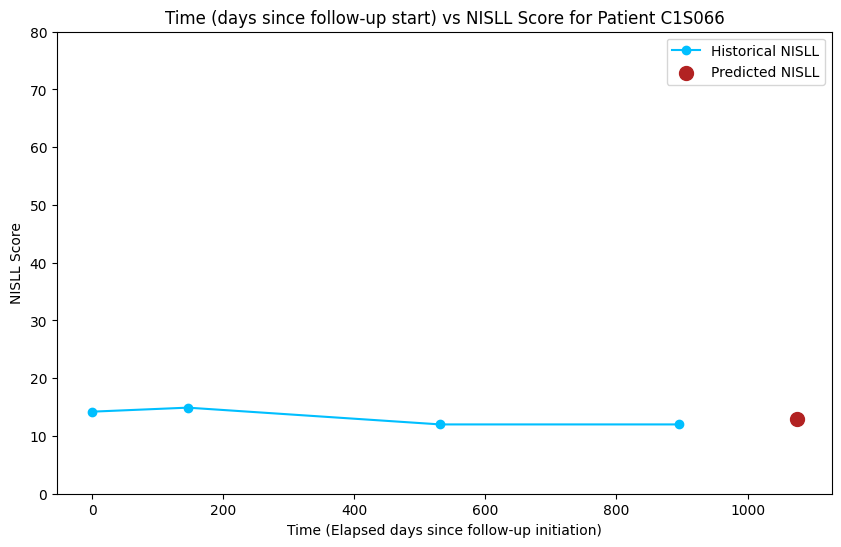

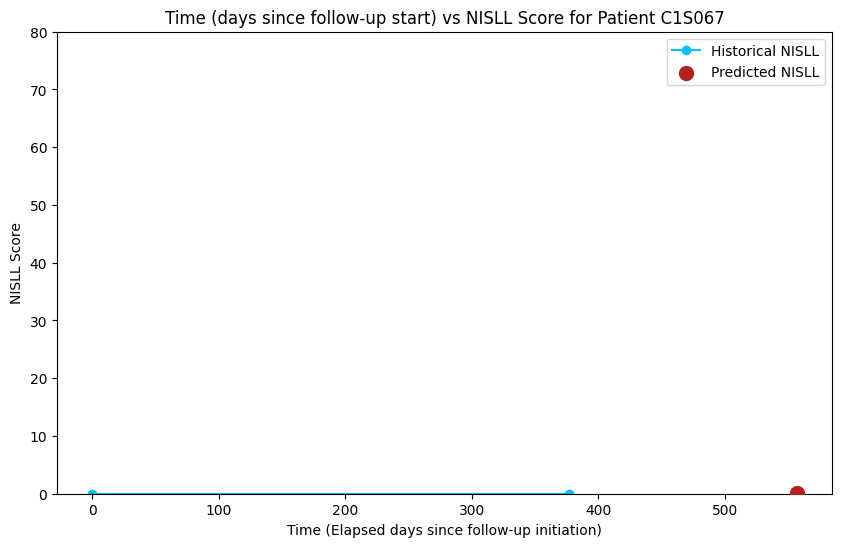

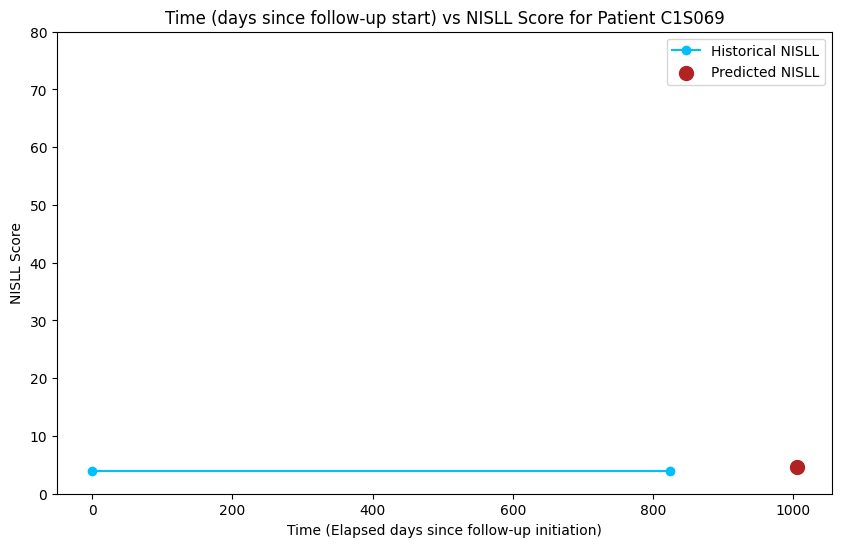

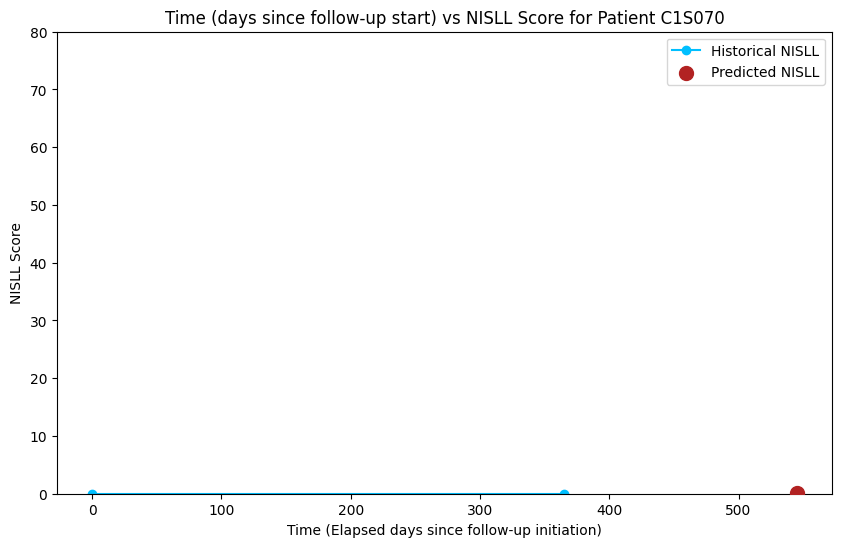

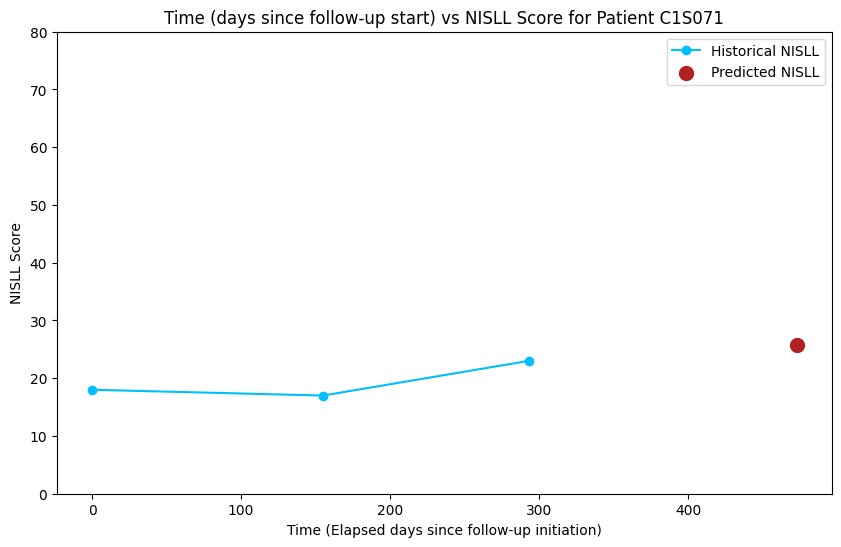

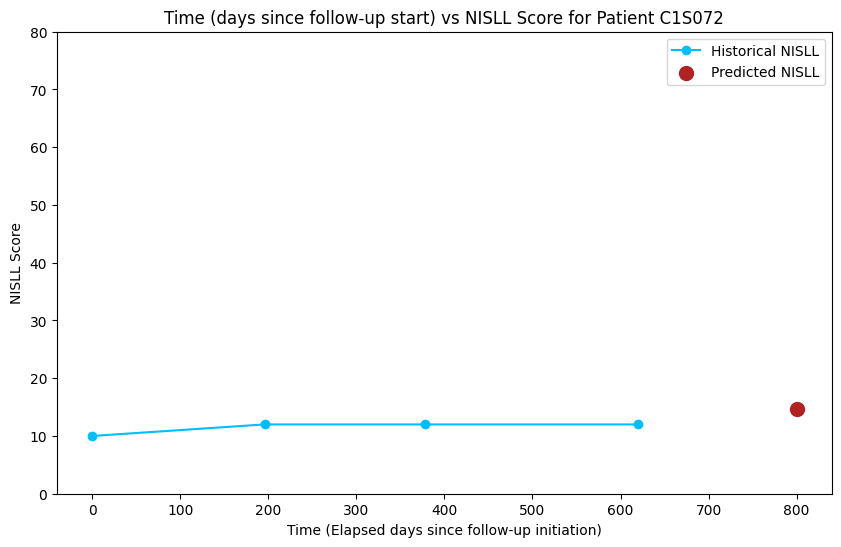

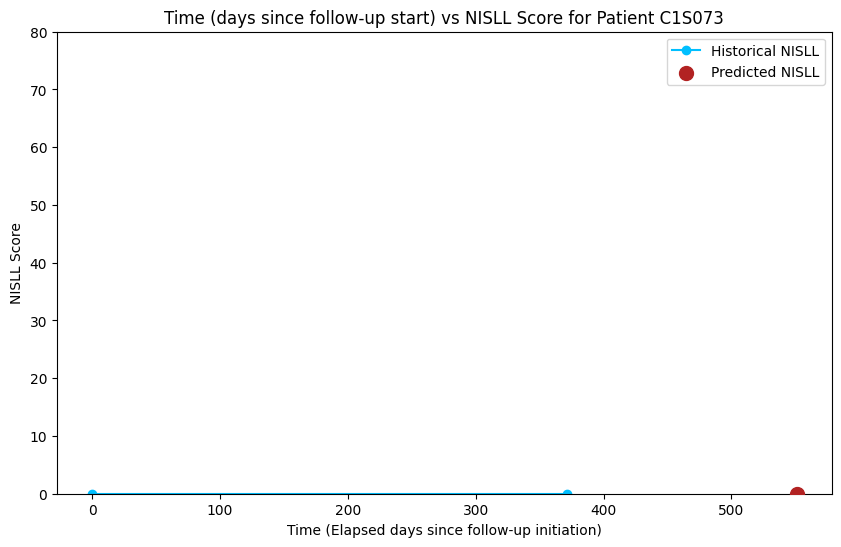

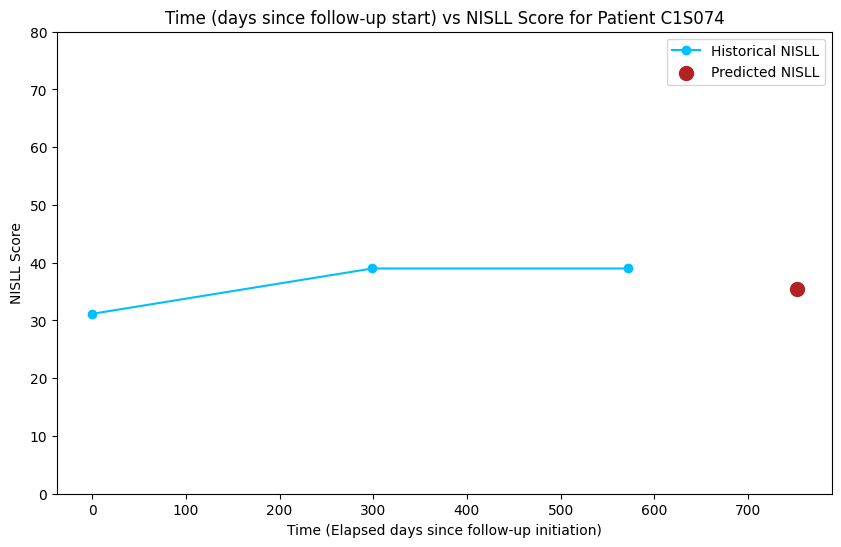

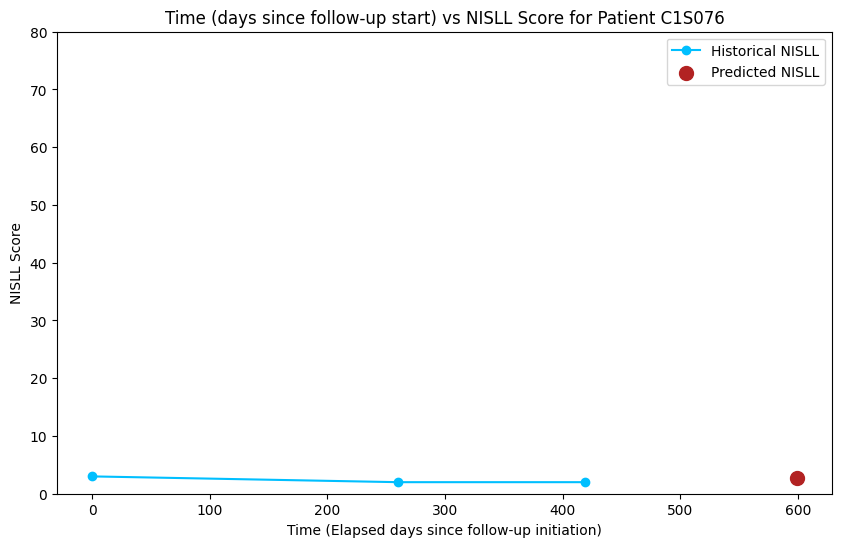

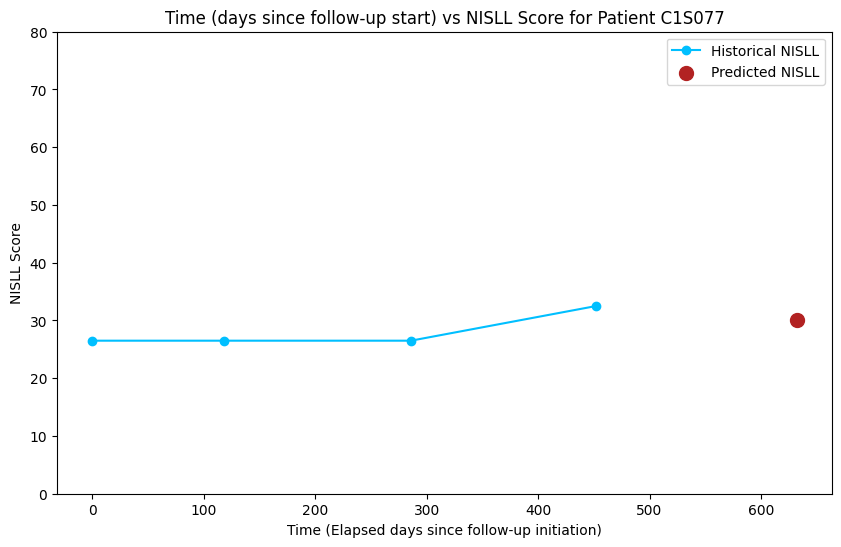

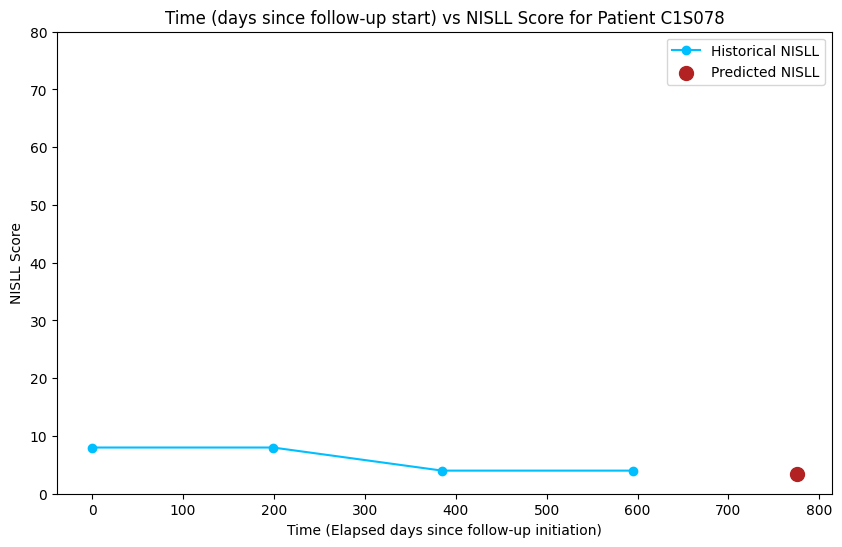

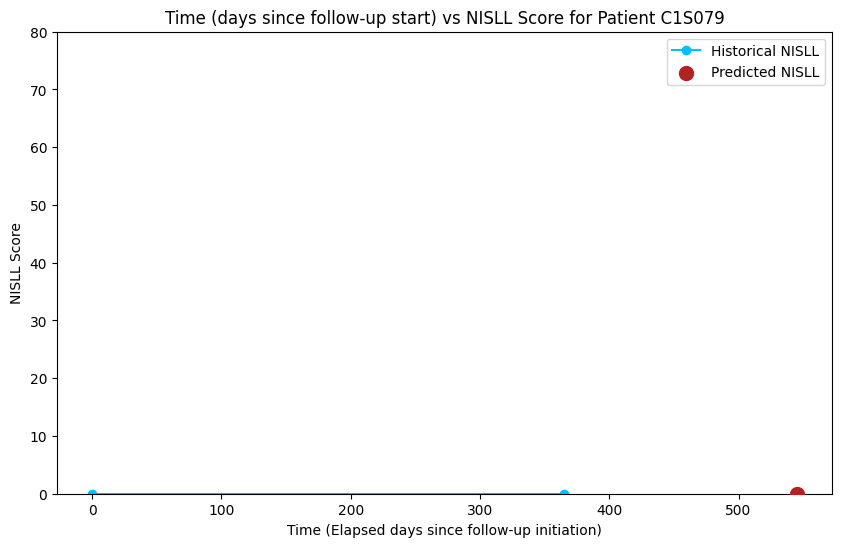

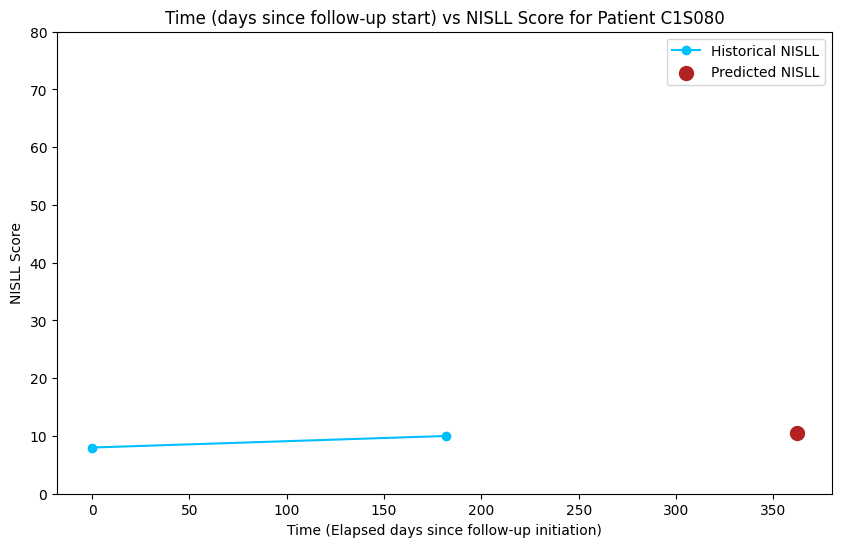

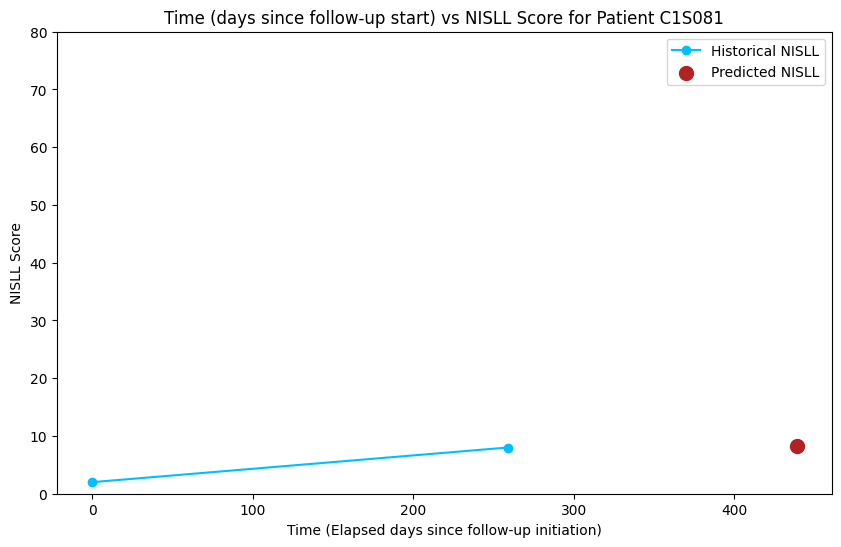

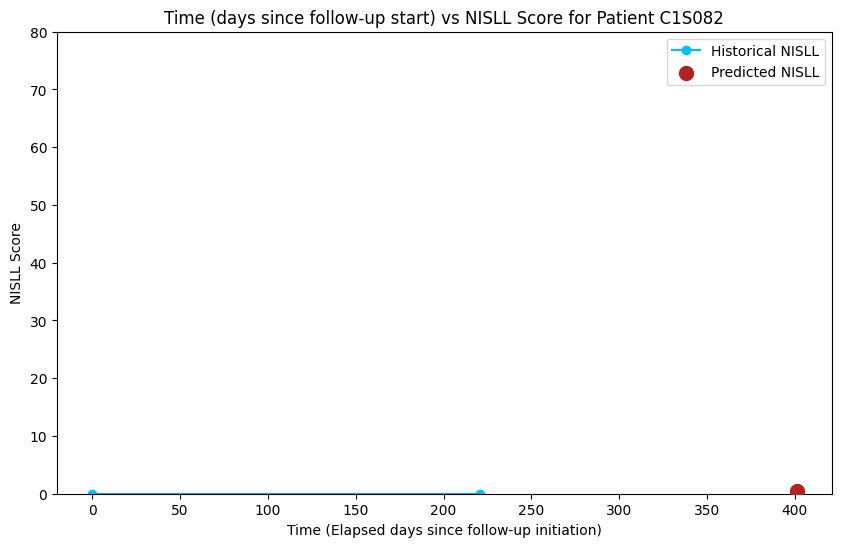

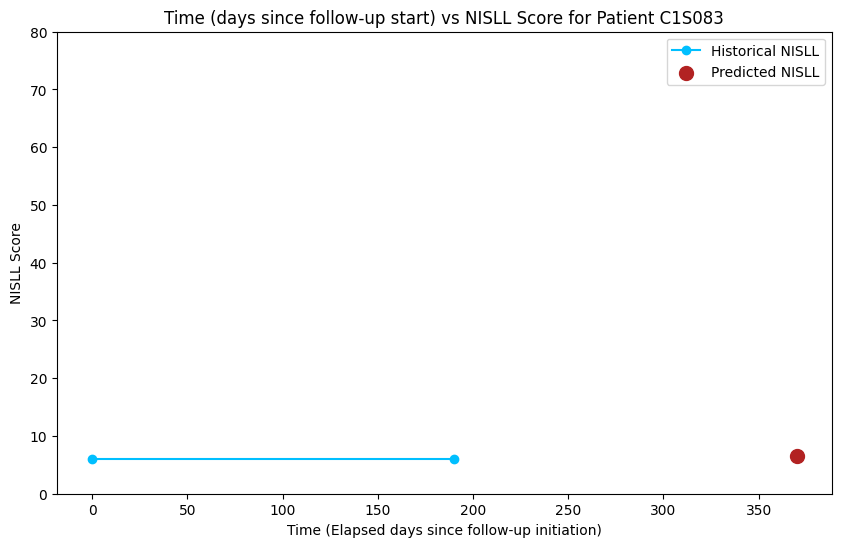

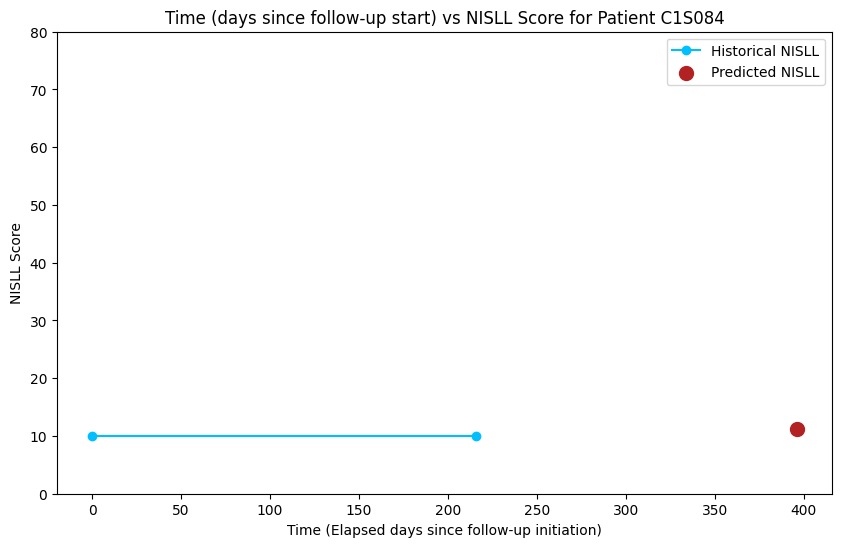

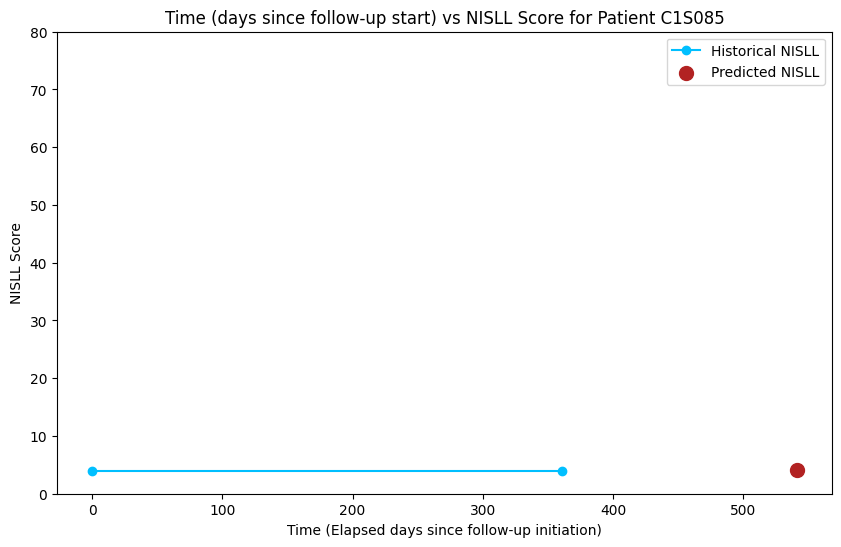

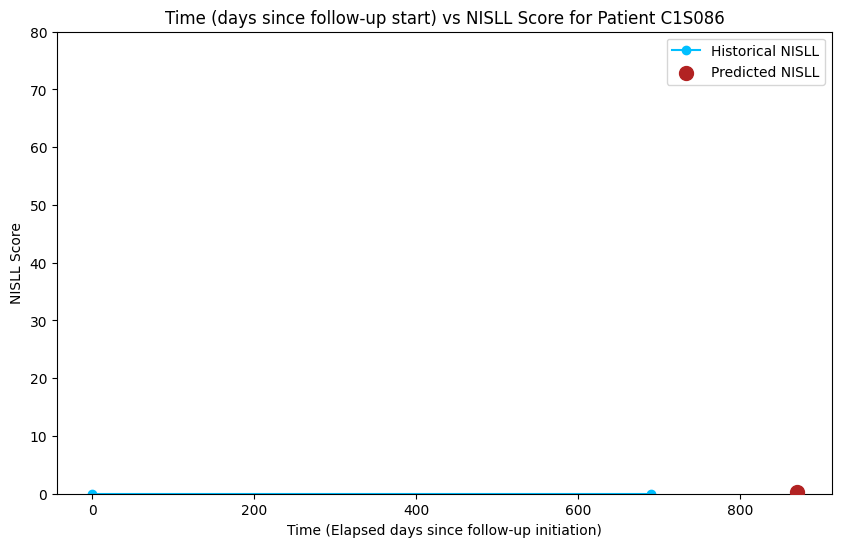

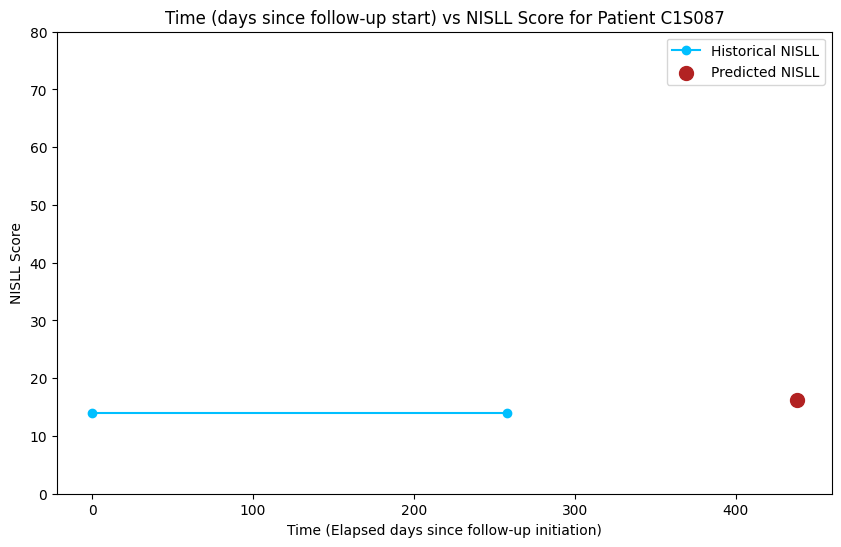

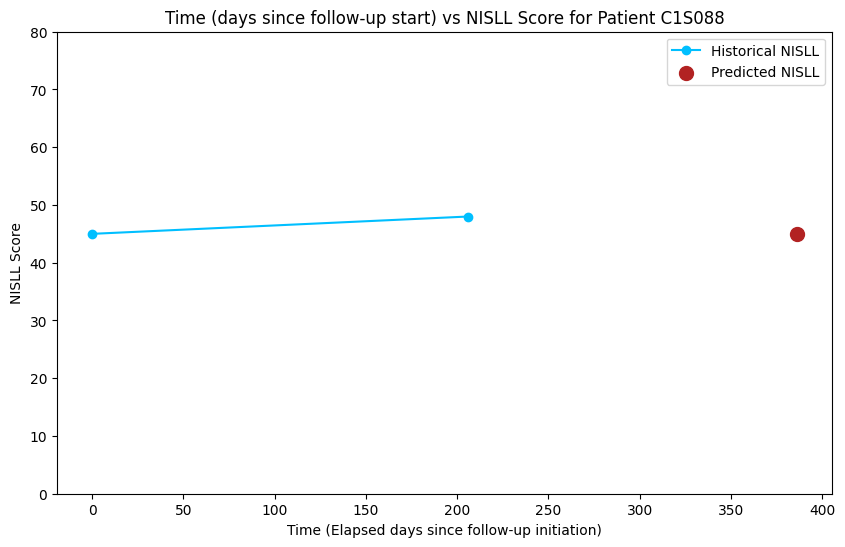

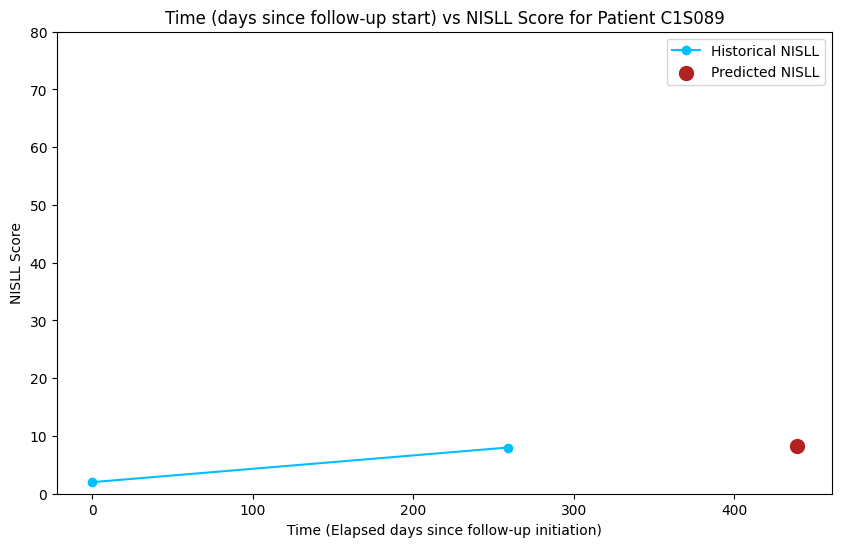

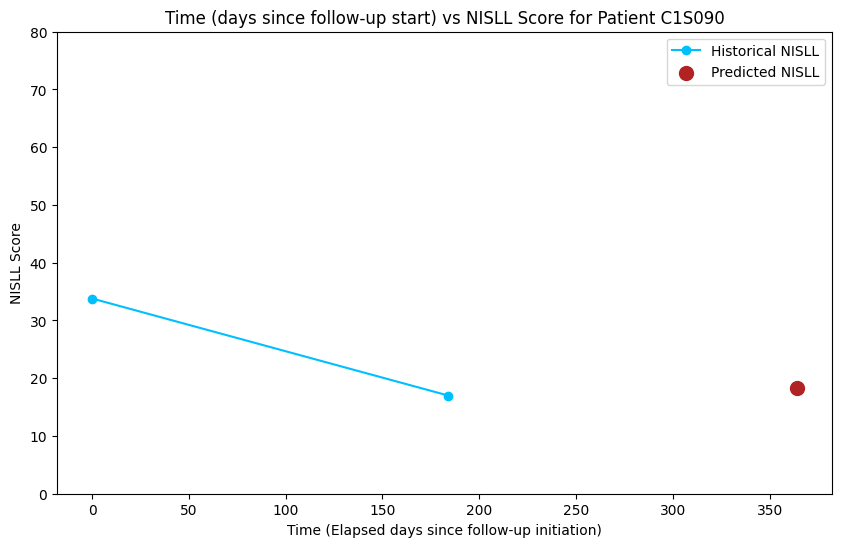

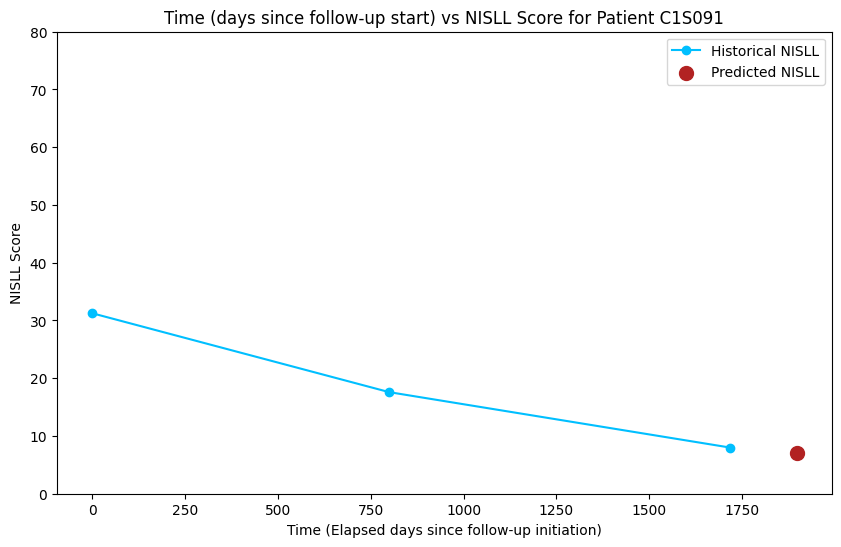

In [117]:
def plot_all_patients(final_df):
    # Step 1: Loop through each unique patient
    for patient in final_df["Patient"].unique():
        # Step 2: Get the patient's data
        patient_data = final_df[final_df["Patient"] == patient]
        
        # Step 3: Separate historical data and predicted data
        historical_data = patient_data[:-1]  # All except the last row
        predicted_data = patient_data.iloc[-1]  # The last row (prediction)
        
        # Step 4: Plot the NISLL vs. time
        plt.figure(figsize=(10, 6))
        
        # Plot historical NISLL vs. Visite_date with softer blue (deepskyblue)
        plt.plot(historical_data["Visite_date"], historical_data["NISLL"], label="Historical NISLL", color='deepskyblue', marker='o', markersize=6, linestyle='-')
        
        # Plot predicted NISLL with firebrick color and open circle
        plt.scatter(predicted_data["Visite_date"], predicted_data["NISLL"], color='firebrick', label="Predicted NISLL", s=100, edgecolors='firebrick', marker='o', zorder=5)
        
        # Add labels and title
        plt.xlabel('Time (Elapsed days since follow-up initiation)')
        plt.ylabel('NISLL Score')
        plt.title(f'Time (days since follow-up start) vs NISLL Score for Patient {patient}')
        
        plt.ylim(bottom=0)
        plt.ylim(top=80)
        
        # Show legend
        plt.legend()
        
        # Show the plot without grid
        plt.show()

# Call the function
plot_all_patients(final_df)


In [135]:
import os
import matplotlib.pyplot as plt

def plot_all_patients_save(final_df, output_folder='figures'):
    # Step 1: Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Step 2: Loop through each unique patient
    for patient in final_df["Patient"].unique():
        # Step 3: Get the patient's data
        patient_data = final_df[final_df["Patient"] == patient]
        
        # Step 4: Separate historical data and predicted data
        historical_data = patient_data[:-1]  # All except the last row
        predicted_data = patient_data.iloc[-1]  # The last row (prediction)
        
        # Step 5: Plot the NISLL vs. time
        plt.figure(figsize=(10, 6))
        
        # Plot historical NISLL vs. Visite_date with softer blue (deepskyblue)
        plt.plot(historical_data["Visite_date"], historical_data["NISLL"], label="Historical NISLL", color='deepskyblue', marker='o', markersize=6, linestyle='-')
        
        # Plot predicted NISLL with firebrick color and open circle
        plt.scatter(predicted_data["Visite_date"], predicted_data["NISLL"], color='firebrick', label="Predicted NISLL", s=100, edgecolors='firebrick', marker='o', zorder=5)
        
        # Add labels and title
        plt.xlabel('Time (Elapsed days since follow-up initiation)')
        plt.ylabel('NISLL Score')
        plt.title(f'Time (days since follow-up start) vs NISLL Score for Patient {patient}')
        
        plt.ylim(bottom=0)
        plt.ylim(top=80)
        
        # Show legend
        plt.legend()
        
        # Save the plot to the folder
        plt.savefig(os.path.join(output_folder, f'patient_{patient}.png'))
        
        # Close the plot to avoid overlapping with the next one
        plt.close()

# Call the function to save the plots
plot_all_patients_save(final_df)


In [136]:
df

,Patient,Visite_date,NISLL,MedianMotorRight_Wrist_ThumbAbduction,MedianMotorLeft_Wrist_ThumbAbduction,UlnarMotorRight_Wrist_FingerAdduction,UlnarMotorLeft_Wrist_FingerAdduction,ExternalPoplitealSciaticMotorRight_Foot_DorsalisPedis,ExternalPoplitealSciaticMotorLeft_Foot_DorsalisPedis,InternalPoplitealSciaticMotorRight_Ankle_CFPI,...,SuralSensitifD,SuralSensoryLeft,MedianVelocityRight,MedianVelocityLeft,MedianDistalLatencyRight,MedianDistalLatencyLeft,Inotersen,Patisiran,Tafamidis,Vutrisiran
0,C1S001,0,12.847826,0.273917,0.535211,0.522054,0.471506,0.083695,0.211538,0.442211,...,0.131757,0.166917,0.551724,0.398658,0.389431,0.426126,0.0,0.0,1.0,0.0
1,C1S001,189,5.503235,0.503317,0.545689,0.473956,0.559885,0.071930,0.403846,0.427136,...,0.236486,0.255639,0.542729,0.483221,0.326346,0.385818,0.0,0.0,1.0,0.0
2,C1S001,373,23.000000,0.434815,0.419877,0.411898,0.481333,0.028947,0.126923,0.386935,...,0.131757,0.131579,0.472264,0.432215,0.378882,0.458767,0.0,0.0,1.0,0.0
3,C1S001,530,11.286869,0.358511,0.379780,0.489031,0.505847,0.024561,0.307692,0.452261,...,0.202703,0.308271,0.540708,0.482706,0.323336,0.375686,0.0,0.0,1.0,0.0
4,C1S001,719,5.489362,0.237875,0.500000,0.664062,0.568966,0.041228,0.211538,0.457286,...,0.172297,0.161654,0.445277,0.488591,0.343089,0.457658,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,C1S090,0,33.800666,0.281125,0.295775,0.367188,0.413793,0.192982,0.211538,0.125628,...,0.000000,0.154135,0.000000,0.312752,0.437398,0.619820,0.0,0.0,1.0,0.0
438,C1S090,184,17.000000,0.302750,0.176056,0.343750,0.387931,0.192982,0.201923,0.125628,...,0.185811,0.086466,0.503748,0.359732,0.392683,0.574775,0.0,0.0,1.0,0.0
439,C1S091,0,31.255567,0.161903,0.197156,0.306497,0.326276,0.166667,0.031731,0.042714,...,0.000000,0.000000,0.356203,0.445638,0.398234,0.407979,0.0,0.0,0.0,0.0
440,C1S091,800,17.587677,0.396458,0.352113,0.437500,0.560345,0.080702,0.122115,0.150754,...,0.000000,0.090226,0.490255,0.645638,0.243089,0.252252,0.0,0.0,1.0,0.0


In [89]:
from tensorflow.keras.layers import LSTM, Dense, Attention, Input
from tensorflow.keras.models import Model

# Define your model architecture with attention
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (timesteps, features)
lstm_out = LSTM(64, return_sequences=True)(inputs)  # Keep the sequence output for attention

# Apply attention: pass the same LSTM output as both query and value
attention = Attention()([lstm_out, lstm_out])  # Query and Value are the same
context_vector = attention[:, -1, :]  # Get the context vector of the last timestep

# Final prediction layer
output = Dense(1)(context_vector)  # Predict NISLL (or other target)
model = Model(inputs, output)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 13, 27)]     0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 13, 64)       23552       ['input_2[0][0]']                
                                                                                                  
 attention_1 (Attention)        (None, 13, 64)       0           ['lstm_3[0][0]',                 
                                                                  'lstm_3[0][0]']                 
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 64)          0           ['attention_1[0][0]']        

Epoch 1/200
8/8 [==============================] - 3s 79ms/step - loss: 84.1610 - mae: 5.4535 - val_loss: 198.8376 - val_mae: 8.3995
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 81.3912 - mae: 5.4413 - val_loss: 191.1518 - val_mae: 8.3135
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 78.7048 - mae: 5.3677 - val_loss: 187.6250 - val_mae: 8.1003
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 76.4534 - mae: 5.2133 - val_loss: 185.2200 - val_mae: 7.9843
Epoch 5/200
8/8 [==============================] - 0s 11ms/step - loss: 74.1370 - mae: 5.1118 - val_loss: 182.7586 - val_mae: 7.9644
Epoch 6/200
8/8 [==============================] - 0s 11ms/step - loss: 72.0399 - mae: 5.0463 - val_loss: 175.4703 - val_mae: 7.7879
Epoch 7/200
8/8 [==============================] - 0s 11ms/step - loss: 70.1795 - mae: 5.0135 - val_loss: 170.8855 - val_mae: 7.6953
Epoch 8/200
8/8 [==============================] - 0s 12ms/step - los

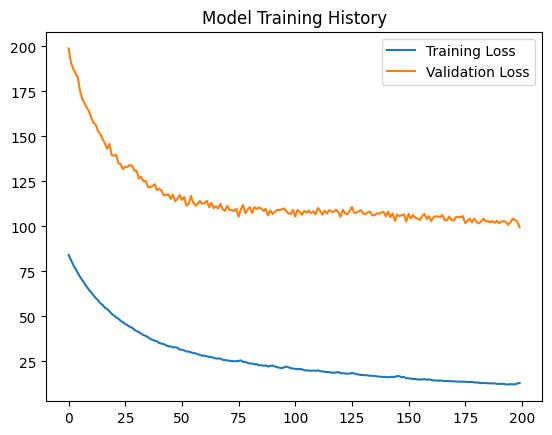

In [99]:
# Assuming X and y are your feature and target arrays
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

# Plot training history (optional)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.show()


2/2 [==============================] - 0s 0s/step


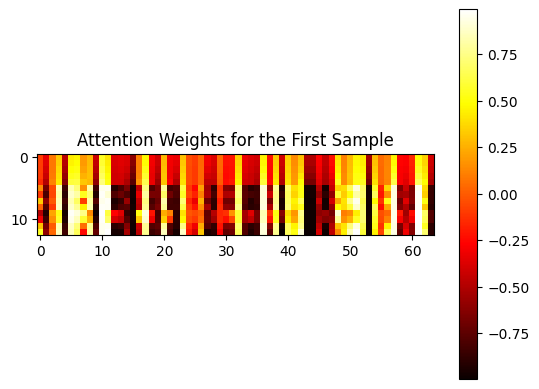

In [100]:

# Get the attention weights (you will need the model to output attention weights)
attention_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[2].output)  # assuming attention is at index 2
attention_weights = attention_model.predict(X_test)

# Visualize attention weights (for a single sample)
# This assumes attention_weights is of shape (num_samples, timesteps, num_features)
sample_attention = attention_weights[10]  # Take the first sample
plt.imshow(sample_attention, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Attention Weights for the First Sample')
plt.show()

In [97]:
df.shape

(442, 29)